In [1]:
import os
import subprocess
# os.environ["HDXER_PATH"] = "/home/alexi/Documents/HDXer"
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

# VDX_dir = '/home/alexi/Documents/ValDX'

VDX_dir = "/home/alexi/Documents/ValDX/"

import sys
sys.path.append(VDX_dir)

from ValDX.VDX_dataclasses import merge_AnalysisData_classes

/home/alexi/Documents/interpretable-hdxer/notebooks/Figure-0_IsoValidation


/home/alexi/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alexi/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def transform_naming(df):
    """
    Transform complex naming patterns in DataFrame to standardized ensemble categories.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'name' column with patterns like
                      'BPTI_10Start_RW_bench_R3_k_sequence'
    
    Returns:
    pd.DataFrame: DataFrame with transformed naming columns
    """
    df = df.copy()
    
    # Extract method and fit from name
    df["protein"] = df["name"].apply(lambda x: x.split("_")[0])
    df["method"] = df["name"].apply(lambda x: x.split("_")[2])

    df["fit"] = df["name"].apply(lambda x: x.split("_")[3])
    

    # Initialize ensemble based on the core system type from name
    def determine_ensemble(name):
        parts = name.split("_")
        
        # Check for start conditions
        if "10Start" in name:
            return "MD-10Start"
        if "1Start" in name:
            return "MD-1Start"
            
        # Check for shaw_400
        if "shaw_400" in name:
            return "MD-Shaw"
            
        # Check for TFES
        if "TFES" in name:
            return "MD-TFES"
        
        if "tri" in name:
            return "ISO-TriModal"
        if "bi" in name:
            return "ISO-BiModal"
        
            
        # Check for clean/dirty
        if ("clean" or "cleaned") in name:
            return "AF2-Filtered"
        if ("dirty" or "MSAss") in name:
            return "AF2-MSAss"
            
        # Default to method if no special case
        return parts[2]
    
    def determine_split_name(split_type):
        if split_type == "r":
            return "Random"
        if split_type == "s":
            return "Sequence"
        if split_type == "R3":
            return "Non-Redundant"
        if split_type == "Sp":
            return "Spatial"
            
    
    df["ensemble"] = df["name"].apply(determine_ensemble)
    
    df["split_type"] = df ["name"].apply(lambda x: x.split("_")[-3])

    df["split_name"] = df["split_type"].apply(determine_split_name)
    df["replicate"] = df["calc_name"].apply(lambda x: x.split("_")[-1])  

    df["analysis"] = df["name"].apply(lambda x: x.split("_")[3])

    return df

In [3]:
ensemble_order =["ISO-BiModal", "ISO-TriModal"]

In [ ]:
dataset_colours = {
    "af_dirty": "navy",
    "af_clean": "cyan",
    "1Start": "pink",
    "10Start": "orange",
    "TFES": "purple"
}

full_dataset_colours = {
    "AF2-MSAss": "navy",
    "AF2-Filtered": "cyan",
    "MD-1Start": "pink",
    "MD-10Start": "orange",
    "MD-TFES": "purple",
    "ISO-BiModal": "indigo",
    "ISO-TriModal": "saddlebrown",
}
split_name_dataset_colours = {
    "Random": "fuchsia",
    "Sequence": "black",
    "Non-Redundant": "green",
    "Spatial": "grey"
}


split_type_dataset_colours = {
    "r": "fuchsia",
    "s": "black",
    "R3": "green",
    "Sp": "grey"
}


split_name_mapping = {
    "r": "Random",
    "s": "Sequence",
    "R3": "Non-Redundant",
    "Sp": "Spatial"
}

# dataset_order = ["af_clean", "1Start"]
full_dataset_order = ["ISO-BiModal", "ISO-TriModal"]

# selet dict elems in full_dataset_order
selected_dataset_colours = {k: full_dataset_colours[k] for k in full_dataset_order if k in full_dataset_colours}



split_name_dataset_order = ["Non-Redundant", "Spatial"]



metric_name_mapping = {
    "delta_H_opt_kj" : "Shape Change ($Work_{shape}$)",
    "-Tdelta_S_opt_kj" : "Redistribution of PFs ($Work_{density}$) ",
    "delta_G_opt_kj" : "Work Done ($Work_{opt}$)",
    "delta_H_abs_kj" : "Uptake-Scale Change ($Work_{scale}$)",
    "dMSE" : "Validation Error Change ($\Delta MSE_{opt}$)",
    "mse" : "Validation Error ($MSE_{Validation}$)"
}


metric_axis_mapping = {
    "delta_H_opt_kj": "$Work_{shape}$ [kJ/mol]",
    "-Tdelta_S_opt_kj": "$Work_{density}$ [kJ/mol]",
    "delta_G_opt_kj": "$Work_{opt}$ [kJ/mol]",
    "delta_H_abs_kj": "$Work_{scale}$ [kJ/mol]",
    "dMSE": "$\Delta MSE_{opt}$",
    "mse": "$MSE_{Validation}$",
    "c_frac1": "Cluster Fraction"
}


protein = "TeaA"
# set plain white style
sns.set_style("ticks")
# set font scales

sns.set_context("paper", rc={
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "xtick.labelsize": 14,
    "ytick.labelsize": 10,
})

In [5]:

results_dir = '/home/alexi/Documents/interpretable-hdxer/data/fig0/RW-only'

# results_dir = "/home/alexi/Documents/ValDX/results/Find-Clusters2"
csvs = glob.glob(results_dir + '/**/*.csv', recursive=True)

# only include csvs that include BPTI

csvs = [csv for csv in csvs if 'TeaA' in csv]

print(len(csvs))


8


In [6]:
pkls = glob.glob(results_dir + '/**/*.pkl', recursive=True)


pkls = [pkl for pkl in pkls if 'TeaA' in pkl]

print(len(pkls))

print(len(pkls))

from ValDX.VDX_dataclasses import merge_AnalysisData_classes

import pickle

# load all the pkls
pkl_list = []
for pkl in pkls:
    with open(pkl, 'rb') as f:
        pkl_list.append(pickle.load(f))


# merge all the pkls
pkl_list = merge_AnalysisData_classes(pkl_list)



8
8
Merging AnalysisData classes
['train_dfs', 'val_dfs', 'expt_df', 'merge_df', 'expt_segs', 'train_segs', 'val_segs', 'HDX_data', 'weights', 'features', 'BV_constants', 'LogPfs', 'analysis_df']


In [7]:
def p_to_stars(p_val):
    """Convert p-value to significance stars."""
    if pd.isna(p_val):
        return 'n.s.'
    elif p_val < 0.0001:
        return '****'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    elif p_val < 0.1:
        return '‡'  # Unicode double dagger (U+2021)
    elif p_val < 0.25:
        return '†'  # Unicode single dagger (U+2020)
    else:
        return 'n.s.'

In [8]:
def extract_protein_name(pkl_list:dict, protein_names: list):
    """
    Extracts the protein name from the name in the dictionary of pandas dataframes
    """

    for key, df in pkl_list.items():
        # iterate through the rows
        for i, row in df.iterrows():
            # print(row["name"])
            # iterate through the protein names
            for protein_name in protein_names:
                # check if the protein name is in the row name
                if protein_name in row["name"]:
                    print(i, protein_name)
                    # if it is, set the protein name to the protein name
                    row["protein"] = protein_name
            df.loc[i] = row
        
        pkl_list[key] = df

                    
    return pkl_list

protein_names = ["BPTI", "HOIP", "BRD4", "LXRa", "MBP", "TeaA"]

pkl_list = extract_protein_name(pkl_list, protein_names)
        
pkl_list["analysis_df"]



0 TeaA
1 TeaA
2 TeaA
3 TeaA
4 TeaA
5 TeaA
6 TeaA
7 TeaA
8 TeaA
9 TeaA
10 TeaA
11 TeaA
12 TeaA
13 TeaA
14 TeaA
15 TeaA
16 TeaA
17 TeaA
18 TeaA
19 TeaA
20 TeaA
21 TeaA
22 TeaA
23 TeaA
24 TeaA
25 TeaA
26 TeaA
27 TeaA
28 TeaA
29 TeaA
30 TeaA
31 TeaA
32 TeaA
33 TeaA
34 TeaA
35 TeaA
36 TeaA
37 TeaA
38 TeaA
39 TeaA
40 TeaA
41 TeaA
42 TeaA
43 TeaA
44 TeaA
45 TeaA
46 TeaA
47 TeaA
48 TeaA
49 TeaA
50 TeaA
51 TeaA
52 TeaA
53 TeaA
54 TeaA
55 TeaA
56 TeaA
57 TeaA
58 TeaA
59 TeaA
60 TeaA
61 TeaA
62 TeaA
63 TeaA
64 TeaA
65 TeaA
66 TeaA
67 TeaA
68 TeaA
69 TeaA
70 TeaA
71 TeaA
72 TeaA
73 TeaA
74 TeaA
75 TeaA
76 TeaA
77 TeaA
78 TeaA
79 TeaA
80 TeaA
81 TeaA
82 TeaA
83 TeaA
84 TeaA
85 TeaA
86 TeaA
87 TeaA
88 TeaA
89 TeaA
90 TeaA
91 TeaA
92 TeaA
93 TeaA
94 TeaA
95 TeaA
96 TeaA
97 TeaA
98 TeaA
99 TeaA
100 TeaA
101 TeaA
102 TeaA
103 TeaA
104 TeaA
105 TeaA
106 TeaA
107 TeaA
108 TeaA
109 TeaA
110 TeaA
111 TeaA
112 TeaA
113 TeaA
114 TeaA
115 TeaA
116 TeaA
117 TeaA
118 TeaA
119 TeaA
120 TeaA
121 TeaA
122 TeaA
123

29 TeaA
30 TeaA
31 TeaA
32 TeaA
33 TeaA
34 TeaA
35 TeaA
36 TeaA
37 TeaA
38 TeaA
39 TeaA
40 TeaA
41 TeaA
42 TeaA
43 TeaA
44 TeaA
45 TeaA
46 TeaA
47 TeaA
48 TeaA
49 TeaA
50 TeaA
51 TeaA
52 TeaA
53 TeaA
54 TeaA
55 TeaA
56 TeaA
57 TeaA
58 TeaA
59 TeaA
60 TeaA
61 TeaA
62 TeaA
63 TeaA
64 TeaA
65 TeaA
66 TeaA
67 TeaA
68 TeaA
69 TeaA
70 TeaA
71 TeaA
72 TeaA
73 TeaA
74 TeaA
75 TeaA
76 TeaA
77 TeaA
78 TeaA
79 TeaA
80 TeaA
81 TeaA
82 TeaA
83 TeaA
84 TeaA
85 TeaA
86 TeaA
87 TeaA
88 TeaA
89 TeaA
90 TeaA
91 TeaA
92 TeaA
93 TeaA
94 TeaA
95 TeaA
96 TeaA
97 TeaA
98 TeaA
99 TeaA
100 TeaA
101 TeaA
102 TeaA
103 TeaA
104 TeaA
105 TeaA
106 TeaA
107 TeaA
108 TeaA
109 TeaA
110 TeaA
111 TeaA
112 TeaA
113 TeaA
114 TeaA
115 TeaA
116 TeaA
117 TeaA
118 TeaA
119 TeaA
120 TeaA
121 TeaA
122 TeaA
123 TeaA
124 TeaA
125 TeaA
126 TeaA
127 TeaA
128 TeaA
129 TeaA
130 TeaA
131 TeaA
132 TeaA
133 TeaA
134 TeaA
135 TeaA
136 TeaA
137 TeaA
138 TeaA
139 TeaA
140 TeaA
141 TeaA
142 TeaA
143 TeaA
144 TeaA
145 TeaA
146 TeaA
147 TeaA


,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class
0,0.167,Train,0.928939,train_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
1,0.167,Val,0.949445,val_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp
2,0.167,Train,0.907175,train_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
3,0.167,Val,0.966791,val_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp
4,0.167,Train,0.937323,train_TeaA_ISO_bi_3,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,120.000,Train,NaN,train_TeaA_ISO_tri_2,0.007508,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,train_R3
516,120.000,Train,NaN,train_TeaA_ISO_tri_3,0.008666,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,train_R3
517,120.000,Val,NaN,val_TeaA_ISO_tri_1,0.010157,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3
518,120.000,Val,NaN,val_TeaA_ISO_tri_2,0.007994,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3


In [95]:
print(pkl_list.keys())

dict_keys(['train_dfs', 'val_dfs', 'expt_df', 'merge_df', 'expt_segs', 'train_segs', 'val_segs', 'HDX_data', 'weights', 'features', 'BV_constants', 'LogPfs', 'analysis_df'])


In [96]:
features = pkl_list["features"]

In [97]:
merge_df = pkl_list["merge_df"]


In [98]:
merge_df["replicate"] = merge_df["calc_name"].apply(lambda x: x.split("_")[-1])

merge_df.columns



Index([       0.167,          1.0,         10.0,         60.0,        120.0,
          'peptide',  'calc_name',     'ResStr',     'ResEnd',       'path',
             'name',     'system',   'analysis', 'split_type',    'protein',
        'name_name',    'dataset',      'class',  'replicate'],
      dtype='object')

In [99]:
# merge_df.ensemble.unique()

In [100]:

def calc_MSE_difference(merge_df:pd.DataFrame, key='mse', prior_dataset='prior', val_dataset='val', exp_dataset="Experimental"):

    # extract only the values that contain the prior dataset
    prior_df = merge_df[merge_df["dataset"]==prior_dataset]

    val_df = merge_df[merge_df["dataset"]==val_dataset]

    exp_df = merge_df[merge_df["dataset"]==exp_dataset]

    systems = prior_df["system"].unique()

    print(len(systems))
    # iterate through the systems

    # create a new dataframe to store the differences
    dMSE_df = pd.DataFrame()

    mean_dMSE_df = pd.DataFrame()

    columns = val_df.columns.tolist()
    print(columns)
    # find all columns that are numbers
    times = [col for col in columns if col != str(col)]

    string_columns = [col for col in columns if col not in times]

    columns_to_remove = ["peptide"]

    final_string_columns = [col for col in string_columns if col not in columns_to_remove]

    # print(times)
    # break


    for system in systems:


        system_prior_df = prior_df[prior_df["system"]==system]
        system_df = val_df[val_df["system"]==system]
        system_exp_df = exp_df[exp_df["system"]==system]
        # print(system_exp_df)

        # break
    # break
        # for each system remove the times that are NaN values to find the valid times for the system
        system_times = [time for time in times if not np.isnan(system_df[time].values).all()]
        print(system_times)

        system_replicates = system_df["replicate"].unique()
        print(system_replicates)
        # break

        for rep in system_replicates:

            system_calc_df = system_df[system_df["replicate"]==rep]
            system_prior_calc_df = system_prior_df[system_prior_df["replicate"]==rep]

            val_peptides = system_calc_df["peptide"].unique()

            system_prior_calc_df = system_prior_calc_df[system_prior_calc_df["peptide"].isin(val_peptides)]

            # system_exp_calc_df = system_exp_df[system_exp_df["replicate"]==rep]

            system_exp_calc_df = system_exp_df[system_exp_df["peptide"].isin(val_peptides)]

            # print(system_exp_calc_df)




            print("system_prior_calc_df")
            print(system_prior_calc_df.peptide.value_counts())
            print("system_calc_df")
            print(system_calc_df.peptide.value_counts())


            df_to_add = system_calc_df.copy()

            for time in system_times:
                print(time)
                print(system_calc_df[time].values)
                print(system_prior_calc_df[time].values)
                # break
                experimental_values = system_exp_calc_df[time].values
                df_to_add[time] = np.abs(system_calc_df[time].values-experimental_values)**2 - np.abs(system_prior_calc_df[time].values-experimental_values)**2

                print(df_to_add[time].values)
                # break


            dMSE_df = pd.concat([dMSE_df, df_to_add])


            # average the dMSE values for each peptide from df_to_add for each system_time
            mean_dMSE = df_to_add.groupby("calc_name")[system_times].mean().values

            mean_dMSE = pd.DataFrame(mean_dMSE, columns=system_times)

            # add the string columns to the mean_dMSE
            for col in string_columns:
                mean_dMSE[col] = df_to_add[col].values[0]

            print(mean_dMSE)

            # pivot mean_dMSE so that the system_time columns are under Time and the value is the dMSE
            mean_dMSE = pd.melt(mean_dMSE, id_vars=final_string_columns, value_vars=system_times, var_name="time", value_name="dMSE")

            print(mean_dMSE)


            mean_dMSE_df = pd.concat([mean_dMSE_df, mean_dMSE])



        #     break
        # break

    column_order = times + string_columns
    # dMSE_df = dMSE_df[column_order]
    # mean_dMSE_df = mean_dMSE_df[column_order]


    return dMSE_df, mean_dMSE_df

dMSE_df, mean_dMSE_df = calc_MSE_difference(merge_df, key='mse', prior_dataset='prior')

8
[0.167, 1.0, 10.0, 60.0, 120.0, 'peptide', 'calc_name', 'ResStr', 'ResEnd', 'path', 'name', 'system', 'analysis', 'split_type', 'protein', 'name_name', 'dataset', 'class', 'replicate']
[0.167, 1.0, 10.0, 60.0, 120.0]
['1' '2' '3']
system_prior_calc_df
peptide
0      1
159    1
182    1
180    1
178    1
      ..
52     1
51     1
50     1
48     1
277    1
Name: count, Length: 133, dtype: int64
system_calc_df
peptide
0      1
159    1
182    1
180    1
178    1
      ..
52     1
51     1
50     1
48     1
277    1
Name: count, Length: 133, dtype: int64
0.167
[1.00000000e+00 1.70703214e-03 1.43491609e-04 6.67300008e-06
 1.31371968e-04 3.69336561e-04 7.67444077e-03 4.40129968e-04
 4.95261154e-01 6.48979962e-02 1.61969223e-03 1.22506091e-03
 7.24419905e-03 2.06756509e-02 1.63677998e-04 6.97497118e-04
 7.32614960e-01 4.42589929e-01 4.70066167e-01 1.00000000e+00
 9.84200524e-01 5.07895250e-02 3.83460356e-04 1.28056908e-03
 2.08564417e-01 3.40889996e-03 1.19275447e-02 6.65974617e-04
 7.469

[0.167, 1.0, 10.0, 60.0, 120.0]
['1' '2' '3']
system_prior_calc_df
peptide
0      1
196    1
229    1
228    1
226    1
      ..
93     1
92     1
84     1
81     1
293    1
Name: count, Length: 133, dtype: int64
system_calc_df
peptide
0      1
196    1
229    1
228    1
226    1
      ..
93     1
92     1
84     1
81     1
293    1
Name: count, Length: 133, dtype: int64
0.167
[1.00000000e+00 2.12937577e-03 1.40313852e-04 5.38124741e-06
 1.14298164e-04 4.91638588e-01 4.66999671e-03 9.35486605e-04
 2.30660111e-04 4.74126423e-04 4.28122978e-01 9.66002536e-01
 2.63766355e-02 2.68943880e-04 1.16034121e-03 1.10456616e-02
 6.75891641e-01 9.70069944e-01 2.55943892e-01 9.98765300e-01
 1.58267183e-04 2.54233645e-03 1.15328209e-04 4.25361581e-03
 7.44788980e-04 4.90892163e-04 1.25366271e-04 2.79450570e-04
 5.25287721e-04 1.21432309e-03 5.97014189e-03 5.48969450e-03
 2.34843051e-02 3.74859181e-01 1.62619152e-02 2.38858965e-01
 3.20558903e-01 2.33067860e-04 1.69779514e-02 1.02904118e-03
 2.3376446

In [101]:
# mean_dMSE_df.ensemble.unique()

In [102]:
weights = pkl_list["weights"]
weights = transform_naming(weights)

In [103]:
# mean_fit_mean_dMSE_df

In [104]:
dMSE_df

# for each time point calculate the mean of the dMSE across all the peptides at each calc_name




,0.167,1.0,10.0,60.0,120.0,peptide,calc_name,ResStr,ResEnd,path,name,system,analysis,split_type,protein,name_name,dataset,class,replicate
690,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,val_TeaA_ISO_bi_1,1.0,2.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,1
691,-2.398309e-09,-8.104024e-08,-6.767222e-06,-8.641810e-05,-9.964591e-05,1,val_TeaA_ISO_bi_1,2.0,3.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,1
692,-9.913858e-12,-1.816447e-10,-2.471933e-08,-8.071004e-07,-2.914971e-06,2,val_TeaA_ISO_bi_1,3.0,4.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,1
693,6.510396e-13,-1.219781e-11,-8.617590e-10,-2.936405e-08,-1.163461e-07,3,val_TeaA_ISO_bi_1,4.0,5.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,1
694,-2.168554e-10,-8.780389e-09,-8.724142e-07,-2.903368e-05,-1.060264e-04,4,val_TeaA_ISO_bi_1,5.0,6.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14881,-8.617226e-07,-2.931042e-05,-1.641300e-03,-2.420485e-03,-2.221364e-04,289,val_TeaA_ISO_tri_3,305.0,306.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,3
14882,-1.843495e-09,-6.604343e-08,-6.277485e-06,-1.700650e-04,-4.835245e-04,290,val_TeaA_ISO_tri_3,306.0,307.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,3
14883,-5.155604e-05,-1.468717e-04,-4.615630e-14,0.000000e+00,0.000000e+00,291,val_TeaA_ISO_tri_3,307.0,308.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,3
14884,-1.285152e-03,-4.374489e-05,0.000000e+00,0.000000e+00,0.000000e+00,292,val_TeaA_ISO_tri_3,308.0,309.0,/home/alexi/Documents/ValDX/figure_scripts/jax...,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,3


In [105]:

mean_dMSE_df = transform_naming(mean_dMSE_df)


fit_mean_dMSE_df = mean_dMSE_df

mean_fit_mean_dMSE_df = fit_mean_dMSE_df.groupby(["name", "replicate", "protein", "split_type"])["dMSE"].mean().reset_index()

In [106]:
dMSE_df = transform_naming(dMSE_df)



dMSE_df["ensemble"].unique()

array(['ISO-BiModal', 'ISO-TriModal'], dtype=object)

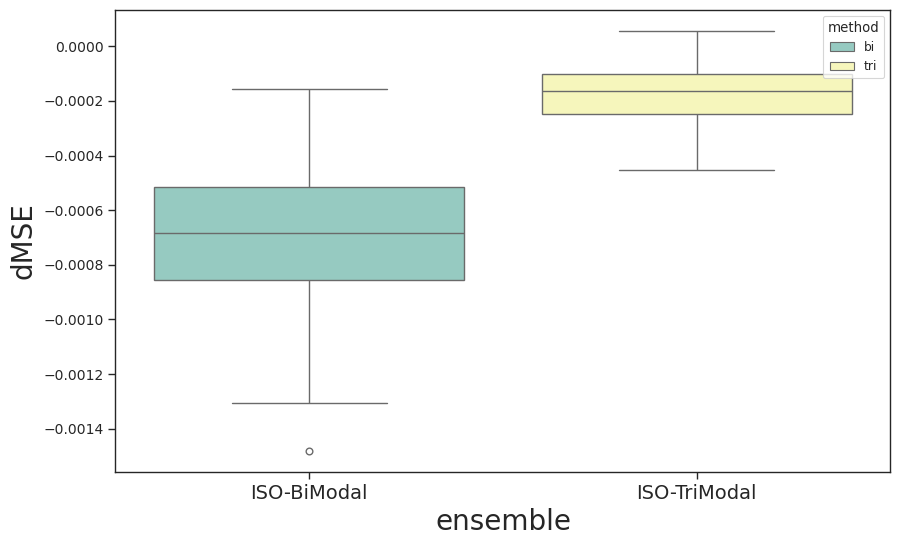

In [107]:
methord_order = ["RW"]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fit_val_df = mean_dMSE_df[mean_dMSE_df["fit"] == "bench"]


sns.boxplot(data=mean_dMSE_df, x="ensemble", y="dMSE", hue="method", ax=ax, palette="Set3")#,order=method_order)
 
# ax.set_yscale("log")

plt.show()


In [108]:

data_frames = []

for csv in csvs:
    data_frames.append(pd.read_csv(csv))

df = pd.concat(data_frames)
df.head()



,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class
0,0.167,Train,0.928939,train_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,RW,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
1,0.167,Val,0.949445,val_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,RW,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp
2,0.167,Train,0.907175,train_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,RW,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
3,0.167,Val,0.966791,val_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,RW,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp
4,0.167,Train,0.937323,train_TeaA_ISO_bi_3,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,RW,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp


In [109]:
#
df["method"] = df["name"].apply(lambda x: x.split("_")[2])

In [110]:
df["fit"] = df["name"].apply(lambda x: x.split("_")[4])

In [111]:
print(df["fit"].unique())    

['bench']


In [112]:
protein_names = ["BPTI", "HOIP", "BRD4", "LXRa", "MBP", "TeaA"]
df['protein'] = df['name'].apply(lambda x: x.split('_')[0])
df

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit
0,0.167,Train,0.928939,train_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,bench
1,0.167,Val,0.949445,val_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,bench
2,0.167,Train,0.907175,train_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,bench
3,0.167,Val,0.966791,val_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,bench
4,0.167,Train,0.937323,train_TeaA_ISO_bi_3,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,bench
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,120.000,Train,NaN,train_TeaA_ISO_tri_2,0.007508,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,train_R3,tri,bench
61,120.000,Train,NaN,train_TeaA_ISO_tri_3,0.008666,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,train_R3,tri,bench
62,120.000,Val,NaN,val_TeaA_ISO_tri_1,0.010157,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,bench
63,120.000,Val,NaN,val_TeaA_ISO_tri_2,0.007994,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,bench


In [113]:
# only include df that has non nan mse values
mse_df = df.dropna(subset=["mse"])
val_df = mse_df[mse_df["Type"] == "Val"]

# remove val mse = 0
val_df = val_df[val_df["mse"] != 0]


print(val_df.method.value_counts())

method
bi     60
tri    60
Name: count, dtype: int64


In [114]:
val_df



,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit
34,0.167,Val,NaN,val_TeaA_ISO_bi_1,0.011000,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,bench
35,0.167,Val,NaN,val_TeaA_ISO_bi_2,0.007390,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,bench
36,0.167,Val,NaN,val_TeaA_ISO_bi_3,0.013551,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,bench
41,1.000,Val,NaN,val_TeaA_ISO_bi_1,0.014072,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,bench
42,1.000,Val,NaN,val_TeaA_ISO_bi_2,0.010361,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,bench
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,60.000,Val,NaN,val_TeaA_ISO_tri_2,0.009942,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,bench
57,60.000,Val,NaN,val_TeaA_ISO_tri_3,0.009443,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,bench
62,120.000,Val,NaN,val_TeaA_ISO_tri_1,0.010157,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,bench
63,120.000,Val,NaN,val_TeaA_ISO_tri_2,0.007994,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,bench


In [115]:
val_df.columns

Index(['time', 'Type', 'R', 'calc_name', 'mse', 'name', 'system', 'analysis',
       'split_type', 'protein', 'name_name', 'dataset', 'class', 'method',
       'fit'],
      dtype='object')

In [116]:
val_df = transform_naming(val_df)
print(val_df["method"].unique())

['bi' 'tri']


In [117]:
split_order = ["r", "s", "R3", "Sp"]


['ISO-BiModal' 'ISO-TriModal']


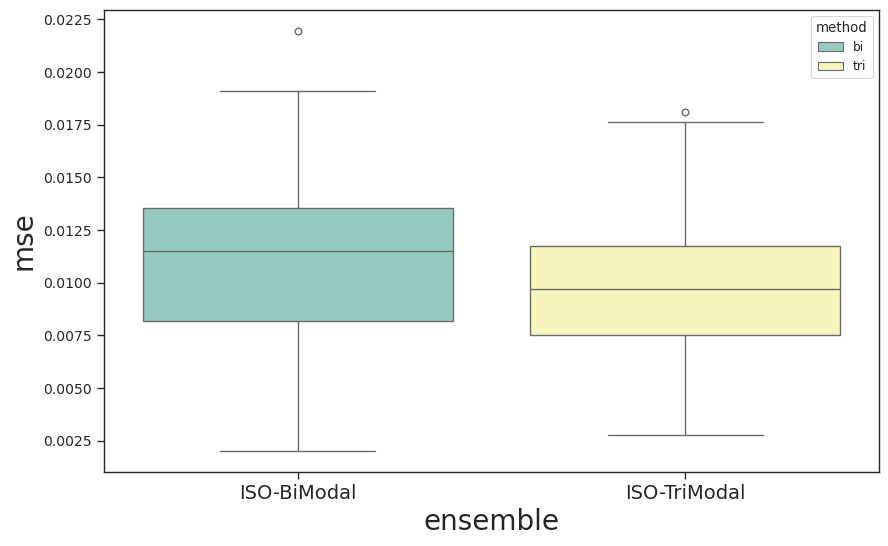

In [118]:
methord_order = ["RW"]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fit_val_df = val_df[val_df["replicate"] != 0]
print(fit_val_df["ensemble"].unique())

sns.boxplot(data=val_df, x="ensemble", y="mse", hue="method", ax=ax, palette="Set3")#,order=method_order)

# ax.set_yscale("log")

plt.show()


In [119]:
fit_val_df = val_df
fit_val_df["ensemble"].unique()

fit_val_df = transform_naming(fit_val_df)

In [120]:
print(val_df.method.value_counts())

method
bi     60
tri    60
Name: count, dtype: int64


In [121]:
expt_segs = pkl_list["expt_segs"]
weightslog_PFs = pkl_list["LogPfs"]
print(expt_segs.columns)
# print(log_PFs.columns)

Index(['ResStr', 'ResEnd', 'peptide', 'calc_name', 'Residue', 'name', 'system',
       'analysis', 'split_type', 'protein', 'name_name', 'dataset', 'class'],
      dtype='object')


In [122]:
expt_segs

,ResStr,ResEnd,peptide,calc_name,Residue,name,system,analysis,split_type,protein,name_name,dataset,class
0,1,2,0,Experimental,"(1, 2)",TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
1,2,3,1,Experimental,"(2, 3)",TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
2,3,4,2,Experimental,"(3, 4)",TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
3,4,5,3,Experimental,"(4, 5)",TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
4,5,6,4,Experimental,"(5, 6)",TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,305,306,289,Experimental,"(305, 306)",TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
2348,306,307,290,Experimental,"(306, 307)",TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
2349,307,308,291,Experimental,"(307, 308)",TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
2350,308,309,292,Experimental,"(308, 309)",TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3


In [123]:
log_PFs = pkl_list["LogPfs"]
log_PFs = transform_naming(log_PFs)
print(log_PFs.ensemble.unique())
print(len(log_PFs.ensemble.unique()))
print(log_PFs.ensemble.value_counts())

['ISO-BiModal' 'ISO-TriModal']
2
ensemble
ISO-BiModal     8655
ISO-TriModal    8655
Name: count, dtype: int64


In [124]:
log_PFs

,Residues,LogPf,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,2,4.429462,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
1,3,11.525572,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
2,4,14.126373,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
3,5,17.142220,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
4,6,14.372941,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17305,306,10.712923,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3
17306,307,11.168799,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3
17307,308,6.072211,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3
17308,309,5.892214,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3


In [125]:

weights

,weights,calc_name,likelihood,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,"[0.0011441647597254005, 0.0011441647597254005,...",prior_TeaA_ISO_bi,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,bi
1,"[0.0011857357475831495, 0.001228942797606991, ...",train_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,1
2,NaN,train_TeaA_ISO_bi_1,1.346915,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,1
3,"[0.001001880537149675, 0.001157126366912108, 0...",train_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,2
4,NaN,train_TeaA_ISO_bi_2,1.654237,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,2
5,"[0.0011731528894211897, 0.0014517722800437677,...",train_TeaA_ISO_bi_3,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,3
6,NaN,train_TeaA_ISO_bi_3,1.363716,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,3
7,"[0.00044943820224719103, 0.0004494382022471910...",prior_TeaA_ISO_tri,NaN,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_prior_...,prior,prior_Sp,tri,RW,ISO-TriModal,Spatial,tri
8,"[0.0003350422591426295, 0.00043465185647202566...",train_TeaA_ISO_tri_1,NaN,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp,tri,RW,ISO-TriModal,Spatial,1
9,NaN,train_TeaA_ISO_tri_1,1.106767,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp,tri,RW,ISO-TriModal,Spatial,1


In [126]:
# explode "weights" array in weights dataframe - such that each element in the array is a new row - labelled by array index in the "frame" column



In [127]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame called 'weights' with a column 'weights' containing arrays
# If not, you can create a sample DataFrame like this:
# weights = pd.DataFrame({'weights': [[1, 2, 3], [4, 5], [6, 7, 8, 9]]})

# Explode the 'weights' column
exploded = weights.explode('weights')

# Reset the index and rename it to 'frame'
exploded = exploded.reset_index().rename(columns={'index': 'frame'})

# If you want 'frame' to represent the index within each array instead of the original DataFrame index,
# you can modify it like this:
exploded['frame'] = exploded.groupby('frame').cumcount()

# Reset the index again to have a clean numeric index
exploded = exploded.reset_index(drop=True)

# Display the result
print(exploded)

       frame   weights             calc_name  likelihood  \
0          0  0.001144     prior_TeaA_ISO_bi         NaN   
1          1  0.001144     prior_TeaA_ISO_bi         NaN   
2          2  0.001144     prior_TeaA_ISO_bi         NaN   
3          3  0.001144     prior_TeaA_ISO_bi         NaN   
4          4  0.001144     prior_TeaA_ISO_bi         NaN   
...      ...       ...                   ...         ...   
49603   2221  0.000532  train_TeaA_ISO_tri_3         NaN   
49604   2222  0.000585  train_TeaA_ISO_tri_3         NaN   
49605   2223    0.0005  train_TeaA_ISO_tri_3         NaN   
49606   2224  0.000388  train_TeaA_ISO_tri_3         NaN   
49607      0       NaN  train_TeaA_ISO_tri_3    1.042604   

                                         name  \
0      TeaA_ISO_bi_RW_bench_Sp_res_neighbours   
1      TeaA_ISO_bi_RW_bench_Sp_res_neighbours   
2      TeaA_ISO_bi_RW_bench_Sp_res_neighbours   
3      TeaA_ISO_bi_RW_bench_Sp_res_neighbours   
4      TeaA_ISO_bi_RW_bench_Sp_res

In [128]:
exploded.frame.value_counts()

frame
0       56
587     32
576     32
577     32
578     32
        ..
1322    16
1321    16
1320    16
1319    16
2224    16
Name: count, Length: 2225, dtype: int64

In [129]:
log_PFs



,Residues,LogPf,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,2,4.429462,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
1,3,11.525572,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
2,4,14.126373,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
3,5,17.142220,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
4,6,14.372941,prior_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17305,306,10.712923,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3
17306,307,11.168799,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3
17307,308,6.072211,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3
17308,309,5.892214,test_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_test_TeaA_...,test,test_R3,tri,RW,ISO-TriModal,Non-Redundant,3


In [130]:
weights

,weights,calc_name,likelihood,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,"[0.0011441647597254005, 0.0011441647597254005,...",prior_TeaA_ISO_bi,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,bi
1,"[0.0011857357475831495, 0.001228942797606991, ...",train_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,1
2,NaN,train_TeaA_ISO_bi_1,1.346915,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,1
3,"[0.001001880537149675, 0.001157126366912108, 0...",train_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,2
4,NaN,train_TeaA_ISO_bi_2,1.654237,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,2
5,"[0.0011731528894211897, 0.0014517722800437677,...",train_TeaA_ISO_bi_3,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,3
6,NaN,train_TeaA_ISO_bi_3,1.363716,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,3
7,"[0.00044943820224719103, 0.0004494382022471910...",prior_TeaA_ISO_tri,NaN,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_prior_...,prior,prior_Sp,tri,RW,ISO-TriModal,Spatial,tri
8,"[0.0003350422591426295, 0.00043465185647202566...",train_TeaA_ISO_tri_1,NaN,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp,tri,RW,ISO-TriModal,Spatial,1
9,NaN,train_TeaA_ISO_tri_1,1.106767,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp,tri,RW,ISO-TriModal,Spatial,1


In [131]:
(features)

,sum_contacts,sum_hbonds,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
1,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_Experi...,Experimental,Experimental_Sp
2,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_bi_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
3,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_s_naive_sequential,TeaA_ISO_tri_RW_bench_s_naive_sequential,RW_bench,s,TeaA,TeaA_ISO_tri_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
4,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_r_naive_random,TeaA_ISO_tri_RW_bench_r_naive_random,RW_bench,r,TeaA,TeaA_ISO_tri_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
5,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_s_naive_sequential,TeaA_ISO_bi_RW_bench_s_naive_sequential,RW_bench,s,TeaA,TeaA_ISO_bi_RW_bench_s_naive_sequential_Experi...,Experimental,Experimental_s
6,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_r_naive_random,TeaA_ISO_bi_RW_bench_r_naive_random,RW_bench,r,TeaA,TeaA_ISO_bi_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
7,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3


In [132]:
BV_constants = pkl_list["BV_constants"]

BV_constants

,Bc,Bh,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp
1,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
2,0.35,2.0,train_TeaA_ISO_bi_2,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
3,0.35,2.0,train_TeaA_ISO_bi_3,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp
4,0.35,2.0,prior_TeaA_ISO_tri,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_prior_...,prior,prior_Sp
5,0.35,2.0,train_TeaA_ISO_tri_1,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp
6,0.35,2.0,train_TeaA_ISO_tri_2,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp
7,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp
8,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_bi_RW_bench_R3_k_sequence_prior_TeaA_...,prior,prior_R3
9,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_bi_RW_bench_R3_k_sequence_train_TeaA_...,train,train_R3


In [133]:
weights

,weights,calc_name,likelihood,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,"[0.0011441647597254005, 0.0011441647597254005,...",prior_TeaA_ISO_bi,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,prior_Sp,bi,RW,ISO-BiModal,Spatial,bi
1,"[0.0011857357475831495, 0.001228942797606991, ...",train_TeaA_ISO_bi_1,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,1
2,NaN,train_TeaA_ISO_bi_1,1.346915,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,1
3,"[0.001001880537149675, 0.001157126366912108, 0...",train_TeaA_ISO_bi_2,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,2
4,NaN,train_TeaA_ISO_bi_2,1.654237,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,2
5,"[0.0011731528894211897, 0.0014517722800437677,...",train_TeaA_ISO_bi_3,NaN,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,3
6,NaN,train_TeaA_ISO_bi_3,1.363716,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,train_Sp,bi,RW,ISO-BiModal,Spatial,3
7,"[0.00044943820224719103, 0.0004494382022471910...",prior_TeaA_ISO_tri,NaN,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_prior_...,prior,prior_Sp,tri,RW,ISO-TriModal,Spatial,tri
8,"[0.0003350422591426295, 0.00043465185647202566...",train_TeaA_ISO_tri_1,NaN,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp,tri,RW,ISO-TriModal,Spatial,1
9,NaN,train_TeaA_ISO_tri_1,1.106767,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_train_...,train,train_Sp,tri,RW,ISO-TriModal,Spatial,1


In [134]:
features

,sum_contacts,sum_hbonds,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
1,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_Experi...,Experimental,Experimental_Sp
2,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_bi_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
3,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_s_naive_sequential,TeaA_ISO_tri_RW_bench_s_naive_sequential,RW_bench,s,TeaA,TeaA_ISO_tri_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
4,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_r_naive_random,TeaA_ISO_tri_RW_bench_r_naive_random,RW_bench,r,TeaA,TeaA_ISO_tri_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
5,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_s_naive_sequential,TeaA_ISO_bi_RW_bench_s_naive_sequential,RW_bench,s,TeaA,TeaA_ISO_bi_RW_bench_s_naive_sequential_Experi...,Experimental,Experimental_s
6,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_r_naive_random,TeaA_ISO_bi_RW_bench_r_naive_random,RW_bench,r,TeaA,TeaA_ISO_bi_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
7,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3


In [135]:
weights.system.unique()


array(['TeaA_ISO_bi_RW_bench_Sp_res_neighbours',
       'TeaA_ISO_tri_RW_bench_Sp_res_neighbours',
       'TeaA_ISO_bi_RW_bench_R3_k_sequence',
       'TeaA_ISO_tri_RW_bench_s_naive_sequential',
       'TeaA_ISO_tri_RW_bench_r_naive_random',
       'TeaA_ISO_bi_RW_bench_s_naive_sequential',
       'TeaA_ISO_bi_RW_bench_r_naive_random',
       'TeaA_ISO_tri_RW_bench_R3_k_sequence'], dtype=object)

In [136]:
features

,sum_contacts,sum_hbonds,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_Experim...,Experimental,Experimental_Sp
1,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,RW_bench,Sp,TeaA,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_Experi...,Experimental,Experimental_Sp
2,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_bi_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
3,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_s_naive_sequential,TeaA_ISO_tri_RW_bench_s_naive_sequential,RW_bench,s,TeaA,TeaA_ISO_tri_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
4,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_r_naive_random,TeaA_ISO_tri_RW_bench_r_naive_random,RW_bench,r,TeaA,TeaA_ISO_tri_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
5,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_s_naive_sequential,TeaA_ISO_bi_RW_bench_s_naive_sequential,RW_bench,s,TeaA,TeaA_ISO_bi_RW_bench_s_naive_sequential_Experi...,Experimental,Experimental_s
6,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...",Experimental,TeaA_ISO_bi_RW_bench_r_naive_random,TeaA_ISO_bi_RW_bench_r_naive_random,RW_bench,r,TeaA,TeaA_ISO_bi_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
7,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...",Experimental,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW_bench,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3


In [137]:
BV_constants.system.unique()

array(['TeaA_ISO_bi_RW_bench_Sp_res_neighbours',
       'TeaA_ISO_tri_RW_bench_Sp_res_neighbours',
       'TeaA_ISO_bi_RW_bench_R3_k_sequence',
       'TeaA_ISO_tri_RW_bench_s_naive_sequential',
       'TeaA_ISO_tri_RW_bench_r_naive_random',
       'TeaA_ISO_bi_RW_bench_s_naive_sequential',
       'TeaA_ISO_bi_RW_bench_r_naive_random',
       'TeaA_ISO_tri_RW_bench_R3_k_sequence'], dtype=object)

In [138]:
expt_segs = pkl_list["expt_segs"]
expt_segs

proteins_num_res = {}

for protein_name in protein_names:
    protein_expt_segs = expt_segs[expt_segs["protein"] == protein_name]

    residue_lists = protein_expt_segs["Residue"].unique()
    # expand list of list
    residues = [residue for residue_list in residue_lists for residue in residue_list]
    residues = list(set(residues))
    proteins_num_res[protein_name] = len(residues)

def calc_energy(features: pd.DataFrame, BV_constants: pd.DataFrame, weights: pd.DataFrame, R=8.31, T=300) -> pd.DataFrame:
    """
    Calculate the energy of the system from the dataframes provided.
    Features contains the sum of the contacts/hbonds for each system,
    these are multiplied by the BV Bc and Bh constants respectively.
    Weights are simply added to the dataframe aligned by calc_name.
    sum_contacts, sum_hbonds, Bc, Bh, weights are arrays of the same length.
    Features are aligned based on "system" as there are multiple replicates designated by calc_name in BV_constants and weights.
    Returns a dataframe with the energy for each system and calc_name.
    """
    # merge BV_constants and weights on calc_name
    # select weights and calc_name columns 
    weights_subset = weights[["calc_name", "weights"]].copy()
    
    # Merge on calc_name instead of concatenating
    merged = BV_constants.merge(weights_subset, on="calc_name", how="inner")
    print(merged.columns)
    print(merged.system.value_counts())

    systems = features.system.unique()
    # iterate through the systems
    features_subset = features[['system', 'sum_contacts', 'sum_hbonds']].copy()

    data_frames = []

    for system in systems:
        print(system)
        system_features = features_subset[features_subset["system"] == system]

        # get the sum_contacts and sum_hbonds
        sum_contacts = system_features["sum_contacts"].to_list()
        sum_hbonds = system_features["sum_hbonds"].to_list()

        system_merged = merged[merged["system"] == system].copy()
        
        # Check if we have the right number of features
        if len(sum_contacts) == 0 or len(sum_hbonds) == 0:
            print(f"Warning: No features found for system {system}")
            continue

        # Handle contacts/hbonds arrays properly
        # Each system has arrays of contacts/hbonds that need to be replicated for each calc_name
        contacts_array = sum_contacts[0] if len(sum_contacts) > 0 else []
        hbonds_array = sum_hbonds[0] if len(sum_hbonds) > 0 else []
        
        # Create lists to store the arrays for each row
        n_rows = len(system_merged)
        system_merged = system_merged.copy()
        system_merged["sum_contacts"] = [contacts_array] * n_rows
        system_merged["sum_hbonds"] = [hbonds_array] * n_rows

        protein = system_merged["protein"].iloc[0]
        num_res = proteins_num_res[protein]

        # calculate the energy (this will be an array for each row since contacts/hbonds are arrays)
        def calc_energy_for_row(row):
            contacts = row["sum_contacts"]
            hbonds = row["sum_hbonds"]
            Bc = row["Bc"]
            Bh = row["Bh"]
            
            if isinstance(contacts, (list, np.ndarray)) and isinstance(hbonds, (list, np.ndarray)):
                energy_array = (Bc * np.array(contacts) + Bh * np.array(hbonds)) * R * T / num_res
                return energy_array
            else:
                # Fallback for scalar values
                return (Bc * contacts + Bh * hbonds) * R * T / num_res
        
        system_merged["energy"] = system_merged.apply(calc_energy_for_row, axis=1)

        # Handle the weights array multiplication properly
        def multiply_weights_energy(row):
            weights_array = row["weights"]
            energy_array = row["energy"]
            
            # Both should be arrays now
            if isinstance(weights_array, (list, np.ndarray)) and isinstance(energy_array, (list, np.ndarray)):
                return np.array(weights_array) * np.array(energy_array)
            elif isinstance(weights_array, (list, np.ndarray)):
                # Energy is scalar, weights is array
                return np.array(weights_array) * energy_array
            elif isinstance(energy_array, (list, np.ndarray)):
                # Weights is scalar, energy is array
                return weights_array * np.array(energy_array)
            else:
                # Both are scalars
                return weights_array * energy_array
        
        system_merged["weighted_energy"] = system_merged.apply(multiply_weights_energy, axis=1)

        # Calculate mean energy by summing the weighted energy arrays
        def sum_weighted_energy(weighted_energy):
            if isinstance(weighted_energy, (list, np.ndarray)):
                return np.sum(weighted_energy)
            else:
                return weighted_energy
                
        system_merged["mean_energy"] = system_merged["weighted_energy"].apply(sum_weighted_energy)

        data_frames.append(system_merged)

    if not data_frames:
        print("Warning: No data frames to concatenate")
        return pd.DataFrame()

    result = pd.concat(data_frames, ignore_index=True)
 
    # remove duplicate columns
    result = result.loc[:,~result.columns.duplicated()]

    return result

energy_df = calc_energy(features, BV_constants, weights)

energy_df = transform_naming(energy_df)
energy_df["replicate"] = energy_df["calc_name"].apply(lambda x: x.split("_")[-1])

Index(['Bc', 'Bh', 'calc_name', 'name', 'system', 'analysis', 'split_type',
       'protein', 'name_name', 'dataset', 'class', 'weights'],
      dtype='object')
system
TeaA_ISO_bi_RW_bench_Sp_res_neighbours      28
TeaA_ISO_bi_RW_bench_R3_k_sequence          28
TeaA_ISO_bi_RW_bench_s_naive_sequential     28
TeaA_ISO_bi_RW_bench_r_naive_random         28
TeaA_ISO_tri_RW_bench_Sp_res_neighbours     28
TeaA_ISO_tri_RW_bench_s_naive_sequential    28
TeaA_ISO_tri_RW_bench_r_naive_random        28
TeaA_ISO_tri_RW_bench_R3_k_sequence         28
Name: count, dtype: int64
TeaA_ISO_bi_RW_bench_Sp_res_neighbours
TeaA_ISO_tri_RW_bench_Sp_res_neighbours
TeaA_ISO_bi_RW_bench_R3_k_sequence
TeaA_ISO_tri_RW_bench_s_naive_sequential
TeaA_ISO_tri_RW_bench_r_naive_random
TeaA_ISO_bi_RW_bench_s_naive_sequential
TeaA_ISO_bi_RW_bench_r_naive_random
TeaA_ISO_tri_RW_bench_R3_k_sequence


In [139]:
# features[features["name"]=="BPTI_MD_Good+Bad_RW_bench_s_naive_sequential"].sum_contacts.values

In [140]:
energy_df

,Bc,Bh,calc_name,name,system,analysis,split_type,protein,name_name,dataset,...,sum_contacts,sum_hbonds,energy,weighted_energy,mean_energy,method,fit,ensemble,split_name,replicate
0,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...","[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi
1,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...","[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi
2,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...","[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi
3,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...","[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi
4,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,"[6919.0, 6943.0, 6857.0, 6834.0, 6898.0, 6796....","[214.0, 221.0, 202.0, 200.0, 212.0, 214.0, 215...","[22916.701451612902, 23096.84080645161, 22549....","[27.17315212786807, 28.384696156563955, 30.202...",22515.081136,bi,RW,ISO-BiModal,Spatial,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...","[22625.98548387097, 22837.48838709677, 22509.3...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,tri,RW,ISO-TriModal,Non-Redundant,3
220,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...","[22625.98548387097, 22837.48838709677, 22509.3...","[8.567448503955912, 8.986421368128426, 7.86923...",22512.007804,tri,RW,ISO-TriModal,Non-Redundant,3
221,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...","[22625.98548387097, 22837.48838709677, 22509.3...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,tri,RW,ISO-TriModal,Non-Redundant,3
222,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[6850.0, 6868.0, 6780.0, 6873.0, 6832.0, 6807....","[208.0, 218.0, 213.0, 206.0, 192.0, 195.0, 212...","[22625.98548387097, 22837.

In [141]:
import numpy as np
from scipy.constants import Boltzmann

def calc_absolute_entropy(energy_df: pd.DataFrame, key="weights", R=8.31):
    """
    Calculates the absolute entropy for the energy dataframe provided.
    The key is the column in the energy_df that contains the weights.
    The entropy is calculated for each array in the weights column.
    
    Parameters:
    energy_df (pd.DataFrame): DataFrame containing the weights
    key (str): Column name for the weights
    T (float): Temperature in Kelvin
    
    Returns:
    pd.DataFrame: Original dataframe with added entropy columns
    """
    
    def entropy(p):
        # Avoid log(0) by adding a small constant
        return -np.sum(p * np.log(p + 1e-10))
    
    entropies = []
    for weights in energy_df[key]:
        # Convert weights to numpy array if it's not already
        weights = np.array(weights)
        
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Calculate entropy
        S = entropy(weights)
        entropies.append(S)
    
    # Add entropy as a new column to the dataframe
    energy_df['Entropy_nats'] = entropies
    
    # Convert entropy to J/K/mol
    energy_df['Entropy_JKmol'] = energy_df['Entropy_nats'] * R
    


    return energy_df

# Usage:
energy_df = calc_absolute_entropy(energy_df)

In [142]:
energy_df

,Bc,Bh,calc_name,name,system,analysis,split_type,protein,name_name,dataset,...,energy,weighted_energy,mean_energy,method,fit,ensemble,split_name,replicate,Entropy_nats,Entropy_JKmol
0,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi,6.773080,56.284297
1,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi,6.773080,56.284297
2,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi,6.773080,56.284297
3,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,"[22916.701451612902, 23096.84080645161, 22549....","[26.22048221008341, 26.42659131172953, 25.7999...",22499.435876,bi,RW,ISO-BiModal,Spatial,bi,6.773080,56.284297
4,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,"[22916.701451612902, 23096.84080645161, 22549....","[27.17315212786807, 28.384696156563955, 30.202...",22515.081136,bi,RW,ISO-BiModal,Spatial,1,6.746967,56.067293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[22625.98548387097, 22837.48838709677, 22509.3...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,tri,RW,ISO-TriModal,Non-Redundant,3,NaN,NaN
220,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[22625.98548387097, 22837.48838709677, 22509.3...","[8.567448503955912, 8.986421368128426, 7.86923...",22512.007804,tri,RW,ISO-TriModal,Non-Redundant,3,7.695184,63.946980
221,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[22625.98548387097, 22837.48838709677, 22509.3...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,tri,RW,ISO-TriModal,Non-Redundant,3,NaN,NaN
222,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,"[22625.98548387097, 22837.48838709677, 22509.3...","[7.57117635126019, 9.36173186534277, 8.2417336...",22512.977128,tri,RW,ISO-TriModal,Non-Redundant,3,7.697402,63.965415


In [143]:
def calc_energy_difference(energy_df: pd.DataFrame, dataset="prior", key="mean_energy", T=300, R=8.31):
    """
    Calculates the energy change upon reweighting from the prior
    """

    systems = energy_df.system.unique()


    dfs= []
    for system in systems:
        # print(system)
        system_df = energy_df[energy_df["system"] == system]
        prior = system_df[system_df["dataset"] == dataset]
        prior_energy = prior[key].values
        # print(prior_energy)
        system_df["signed_energy_difference"] = system_df[key].values - prior_energy
        # take absolute value
        system_df["energy_difference"] = system_df["signed_energy_difference"].apply(lambda x: np.abs(x))
        # print(system_df["energy_difference"])
        system_df["%_energy_difference"] = system_df["energy_difference"].apply(lambda x: 100*x/np.abs(prior_energy))

        # convert %_energy_difference from a list
        system_df["%_energy_difference"] = system_df["%_energy_difference"].apply(lambda x: x[0])



        system_df["ratio_energy_difference"] = system_df["%_energy_difference"].apply(lambda x: x/100+1)


        system_df["entropy_difference"] = system_df["Entropy_JKmol"].values - prior["Entropy_JKmol"].values

        system_df["signed_enthalpy"] = system_df["signed_energy_difference"] 

        print(system_df.entropy_difference.values)

        system_df["gibbs_free_energy"] = system_df["energy_difference"] - T*system_df["entropy_difference"]

        # convert to equilibrium constant
        system_df["equilibrium_constant"] = system_df["gibbs_free_energy"].apply(lambda x: np.exp(-x/(R*T)))


   
        dfs.append(system_df)

    energy_df = pd.concat(dfs)

    return energy_df


def calc_energy_difference(energy_df: pd.DataFrame, dataset="prior", key="mean_energy", T=300, R=8.31):
    """
    Calculates the energy change upon reweighting from the prior
    """
    systems = energy_df.system.unique()
    dfs = []
    
    for system in systems:
        print(f"Processing system: {system}")
        system_df = energy_df[energy_df["system"] == system].copy()
        prior = system_df[system_df["dataset"] == dataset]
        
        if len(prior) == 0:
            print(f"Warning: No prior data found for system {system}")
            raise ValueError(f"No prior data found for system {system}")
            
        # Handle case where there might be multiple prior entries
        if len(prior) > 1:
            print(f"Warning: Multiple prior entries found for system {system}, using first one")
            prior_energy = prior[key].iloc[0]
            prior_entropy = prior["Entropy_JKmol"].iloc[0]
        else:
            prior_energy = prior[key].iloc[0]
            prior_entropy = prior["Entropy_JKmol"].iloc[0]
        
        print(f"Prior energy: {prior_energy}")
        print(f"System energies shape: {system_df[key].values.shape}")
        
        # Calculate differences - now broadcasting should work since prior_energy is scalar
        system_df["signed_energy_difference"] = system_df[key].values - prior_energy
        
        # Take absolute value
        system_df["energy_difference"] = system_df["signed_energy_difference"].apply(lambda x: np.abs(x))
        
        # Handle percentage calculation - check if prior_energy is zero
        if np.abs(prior_energy) > 1e-10:  # Avoid division by zero
            system_df["%_energy_difference"] = system_df["energy_difference"].apply(
                lambda x: 100 * x / np.abs(prior_energy)
            )
        else:
            system_df["%_energy_difference"] = 0
            
        # Handle the case where %_energy_difference might be an array
        def extract_percentage(x):
            if isinstance(x, (list, np.ndarray)) and len(x) > 0:
                return x[0] if hasattr(x, '__len__') else x
            return x
            
        system_df["%_energy_difference"] = system_df["%_energy_difference"].apply(extract_percentage)
        system_df["ratio_energy_difference"] = system_df["%_energy_difference"].apply(lambda x: x/100 + 1)
        
        # Calculate entropy difference
        system_df["entropy_difference"] = system_df["Entropy_JKmol"].values - prior_entropy
        system_df["signed_enthalpy"] = system_df["signed_energy_difference"]
        
        print(f"Entropy differences: {system_df['entropy_difference'].values}")
        
        # Calculate Gibbs free energy
        system_df["gibbs_free_energy"] = system_df["energy_difference"] - T * system_df["entropy_difference"]
        
        # Convert to equilibrium constant
        system_df["equilibrium_constant"] = system_df["gibbs_free_energy"].apply(
            lambda x: np.exp(-x/(R*T)) if not np.isnan(x) else np.nan
        )
        
        dfs.append(system_df)
    
    if not dfs:
        print("Warning: No data to concatenate")
        return pd.DataFrame()
        
    energy_df_result = pd.concat(dfs, ignore_index=True)
    return energy_df_result
energy_df = calc_energy_difference(energy_df)

energy_df.columns

Processing system: TeaA_ISO_bi_RW_bench_Sp_res_neighbours
Prior energy: 22499.43587565513
System energies shape: (28,)
Entropy differences: [ 0.          0.          0.          0.         -0.21700385         nan
 -0.19521409         nan -0.16268686         nan -0.12837991         nan
 -0.44819389         nan -0.09700778         nan -0.190115           nan
 -0.1651727          nan -0.19713185         nan -0.07777995         nan
 -0.15802479         nan -0.20233998         nan]
Processing system: TeaA_ISO_tri_RW_bench_Sp_res_neighbours
Prior energy: 22501.3672901776
System energies shape: (28,)
Entropy differences: [ 0.          0.          0.          0.         -0.10904413         nan
 -0.09141721         nan -0.08178261         nan -0.09822179         nan
 -0.15185792         nan -0.08727578         nan -0.09451679         nan
 -0.06362786         nan -0.05704133         nan -0.07304568         nan
 -0.10244461         nan -0.08400994         nan]
Processing system: TeaA_ISO_bi_RW_be

Index(['Bc', 'Bh', 'calc_name', 'name', 'system', 'analysis', 'split_type',
       'protein', 'name_name', 'dataset', 'class', 'weights', 'sum_contacts',
       'sum_hbonds', 'energy', 'weighted_energy', 'mean_energy', 'method',
       'fit', 'ensemble', 'split_name', 'replicate', 'Entropy_nats',
       'Entropy_JKmol', 'signed_energy_difference', 'energy_difference',
       '%_energy_difference', 'ratio_energy_difference', 'entropy_difference',
       'signed_enthalpy', 'gibbs_free_energy', 'equilibrium_constant'],
      dtype='object')

In [144]:
energy_df.ensemble.unique()

array(['ISO-BiModal', 'ISO-TriModal'], dtype=object)

In [145]:
energy_df

,Bc,Bh,calc_name,name,system,analysis,split_type,protein,name_name,dataset,...,Entropy_nats,Entropy_JKmol,signed_energy_difference,energy_difference,%_energy_difference,ratio_energy_difference,entropy_difference,signed_enthalpy,gibbs_free_energy,equilibrium_constant
0,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,6.773080,56.284297,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
1,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,6.773080,56.284297,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
2,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,6.773080,56.284297,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
3,0.35,2.0,prior_TeaA_ISO_bi,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_prior_T...,prior,...,6.773080,56.284297,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
4,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,6.746967,56.067293,15.645261,15.645261,0.069536,1.000695,-0.217004,15.645261,80.746416,0.968130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,7.695184,63.946980,10.640514,10.640514,0.047288,1.000473,-0.102445,10.640514,41.373898,0.983541
221,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,7.697402,63.965415,11.609838,11.609838,0.051596,1.000516,-0.084010,11.609838,36.812821,0.985342


In [146]:
# merge MSE and energy dataframes
# fit_val_df 

mse_fit_val_df = fit_val_df[fit_val_df["mse"]!=0]

mean_fit_val_df = mse_fit_val_df.groupby(["name", "replicate", "protein", "split_type"])["mse"].mean().reset_index()


mean_fit_val_df

,name,replicate,protein,split_type,mse
0,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,TeaA,R3,0.014307
1,TeaA_ISO_bi_RW_bench_R3_k_sequence,2,TeaA,R3,0.015887
2,TeaA_ISO_bi_RW_bench_R3_k_sequence,3,TeaA,R3,0.012751
3,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,1,TeaA,Sp,0.011924
4,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,2,TeaA,Sp,0.005099
5,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,3,TeaA,Sp,0.011325
6,TeaA_ISO_bi_RW_bench_r_naive_random,1,TeaA,r,0.010880
7,TeaA_ISO_bi_RW_bench_r_naive_random,2,TeaA,r,0.012087
8,TeaA_ISO_bi_RW_bench_r_naive_random,3,TeaA,r,0.008044
9,TeaA_ISO_bi_RW_bench_s_naive_sequential,1,TeaA,s,0.010716


In [147]:
RW_energy_df = energy_df[energy_df["dataset"]!= "prior"]

RW_energy_df = transform_naming(RW_energy_df)

RW_energy_df.ensemble.unique()

array(['ISO-BiModal', 'ISO-TriModal'], dtype=object)

In [148]:
RW_mean_fit_val_df = mean_fit_val_df[["name", "replicate", "mse"]]

MSE_energy_df = pd.merge(RW_mean_fit_val_df, RW_energy_df, on=["name", "replicate"], how="outer")

MSE_energy_df.ensemble.unique()


array(['ISO-BiModal', 'ISO-TriModal'], dtype=object)

In [149]:
mean_fit_mean_dMSE_df

,name,replicate,protein,split_type,dMSE
0,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,TeaA,R3,-0.000771
1,TeaA_ISO_bi_RW_bench_R3_k_sequence,2,TeaA,R3,-0.000675
2,TeaA_ISO_bi_RW_bench_R3_k_sequence,3,TeaA,R3,-0.000546
3,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,1,TeaA,Sp,-0.000803
4,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,2,TeaA,Sp,-0.000388
5,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,3,TeaA,Sp,-0.000749
6,TeaA_ISO_bi_RW_bench_r_naive_random,1,TeaA,r,-0.000786
7,TeaA_ISO_bi_RW_bench_r_naive_random,2,TeaA,r,-0.000817
8,TeaA_ISO_bi_RW_bench_r_naive_random,3,TeaA,r,-0.000857
9,TeaA_ISO_bi_RW_bench_s_naive_sequential,1,TeaA,s,-0.000719


In [150]:
RW_energy_df

,Bc,Bh,calc_name,name,system,analysis,split_type,protein,name_name,dataset,...,Entropy_nats,Entropy_JKmol,signed_energy_difference,energy_difference,%_energy_difference,ratio_energy_difference,entropy_difference,signed_enthalpy,gibbs_free_energy,equilibrium_constant
4,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,6.746967,56.067293,15.645261,15.645261,0.069536,1.000695,-0.217004,15.645261,80.746416,0.968130
5,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,6.749589,56.089083,14.224637,14.224637,0.063222,1.000632,-0.195214,14.224637,72.788865,0.971225
7,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_train_T...,train,...,6.753503,56.121610,12.839662,12.839662,0.057067,1.000571,-0.162687,12.839662,61.645721,0.975576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,7.695184,63.946980,10.640514,10.640514,0.047288,1.000473,-0.102445,10.640514,41.373898,0.983541
221,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_train_TeaA...,train,...,7.697402,63.965415,11.609838,11.609838,0.051596,1.000516,-0.084010,11.609838,36.812821,0.985342


In [151]:
RW_mean_fit_mean_dMSE_df = mean_fit_mean_dMSE_df[["name", "replicate", "dMSE"]]

dMSE_energy_df = pd.merge(RW_mean_fit_mean_dMSE_df, RW_energy_df, on=["name", "replicate"], how="outer")


In [152]:

dMSE_energy_df.ensemble.unique()


array(['ISO-BiModal', 'ISO-TriModal'], dtype=object)

In [153]:
MSE_energy_df["%_energy_difference"].values

array([0.06953624,        nan, 0.06322219,        nan, 0.05706659,
              nan, 0.08146628,        nan, 0.08229834,        nan,
       0.03384921,        nan, 0.05892118,        nan, 0.06784259,
              nan, 0.04886339,        nan, 0.03413737,        nan,
       0.04617867,        nan, 0.05485398,        nan, 0.06953624,
              nan, 0.06322219,        nan, 0.05706659,        nan,
       0.08146628,        nan, 0.08229834,        nan, 0.03384921,
              nan, 0.05892118,        nan, 0.06784259,        nan,
       0.04886339,        nan, 0.03413737,        nan, 0.04617867,
              nan, 0.05485398,        nan, 0.06953624,        nan,
       0.06322219,        nan, 0.05706659,        nan, 0.08146628,
              nan, 0.08229834,        nan, 0.03384921,        nan,
       0.05892118,        nan, 0.06784259,        nan, 0.04886339,
              nan, 0.03413737,        nan, 0.04617867,        nan,
       0.05485398,        nan, 0.06953624,        nan, 0.06322

In [154]:
import numpy as np
import pandas as pd
log_PF_df = pkl_list["LogPfs"]


def calc_pmf(logPfs: pd.DataFrame, R=8.31, T=300):
    """
    Calculates ensemble-average conformational and optimization thermodynamic quantities at each residue position.
    Returns a tuple of two dataframes: (result_df, ensemble_df)
    
    Calculates:
    - Optimization metrics (opt): Total changes during optimization
    - Conformational metrics (conf): Changes in conformational dynamics at fixed interaction strength
    """
    logPfs = logPfs.copy()
    logPfs["rep"] = logPfs["calc_name"].apply(lambda x: x.split("_")[-1])
    logPfs["system_name"] = logPfs["system"] + "_" + logPfs["rep"]
    logPfs = logPfs[logPfs["dataset"] != "val"]
    
    systems = logPfs.system_name.unique()
    dfs = []
    ensemble_data = []
    
    for system in systems:
        # Get data for this system
        system_df = logPfs[logPfs["system_name"] == system].copy()
        
        # Calculate initial metrics for all data points
        system_df["beta_star"] = system_df.groupby("calc_name")["LogPf"].transform("std")/(R*T)
        system_df["avg_logPF"] = system_df.groupby("calc_name")["LogPf"].transform("mean")
        system_df["log_delta_PFi"] = np.abs(system_df["LogPf"] - system_df["avg_logPF"])
        system_df["N_quanta"] = system_df["log_delta_PFi"] / system_df["beta_star"]
        
        # Get prior data after calculating initial metrics
        prior_df = system_df[system_df["dataset"] == "prior"].copy()


        # Calculate delta metrics using prior data
        system_df["delta_beta_star"] = system_df["beta_star"] - prior_df["beta_star"].iloc[0]
        system_df["delta_avg_logPF"] = np.abs(system_df["avg_logPF"] - prior_df["avg_logPF"].iloc[0])
        system_df["delta_N_quanta"] = system_df["N_quanta"] - prior_df["N_quanta"].iloc[0]
        
        # Calculate enthalpies
        system_df["H_opt"] = R * T * system_df["log_delta_PFi"].abs()
        system_df["H_conf"] = R * T * system_df["beta_star"] * np.abs(system_df["delta_N_quanta"])
        system_df["H_interaction"] = R * T * np.abs(system_df["delta_beta_star"]) * system_df["N_quanta"]
        
        # Calculate partition function and probabilities
        system_df["omega_opt"] = R*T*np.log(system_df.groupby("calc_name")["log_delta_PFi"].transform("sum"))
        # system_df["Z_opt"] = 1/np.exp(-system_df["omega_opt"] / (R * T))
        system_df["q"] = np.exp(-system_df["log_delta_PFi"].abs())
        system_df["Z_opt"] = system_df.groupby("calc_name")["q"].transform("sum")
        print(system_df["Z_opt"])


        system_df["Pi_opt"] = system_df["Z_opt"] * np.exp(-system_df["H_opt"].abs() / (R * T))
        system_df["Pi_conf"] = system_df["Z_opt"] * np.exp(-system_df["H_conf"] / (R * T))
        
        # Calculate entropy terms
        system_df["S_opt"] = -R * system_df["Pi_opt"] * np.log(system_df["Pi_opt"])
        system_df["S_conf"] = -R * system_df["Pi_conf"] * np.log(system_df["Pi_conf"])
        
        # Calculate TdS terms
        system_df["TdS_opt"] = T * system_df["S_opt"]
        system_df["TdS_conf"] = T * system_df["S_conf"]
        
        # Calculate Gibbs free energy terms
        system_df["G_opt"] = system_df["H_opt"] - T * system_df["S_opt"]
        system_df["G_conf"] = system_df["H_conf"] - T * system_df["S_conf"]
        system_df["G_quasi"] = (R*T * system_df.groupby("calc_name")["delta_avg_logPF"].transform("mean")) - T * system_df["S_opt"]
        
        # Convert to kJ/mol
        for metric in ["H_opt", "H_conf", "H_interaction", "S_opt", "S_conf", "G_opt", "G_conf"]:
            system_df[f"{metric}_kj"] = system_df[metric] / 1000
        
        system_df["TdS_opt_kj"] = system_df["TdS_opt"] / 1000
        system_df["TdS_conf_kj"] = system_df["TdS_conf"] / 1000
        
        dfs.append(system_df)
        
        # Calculate ensemble averages for test data
        test_df = system_df[system_df["dataset"] == "test"].copy()
        prior_df = system_df[system_df["dataset"] == "prior"].copy()

            
        # Create aligned prior and test dataframes based on shared indices
        common_cols = test_df.columns.intersection(prior_df.columns)
        test_data = test_df[common_cols]
        prior_data = prior_df[common_cols]
        
        # Ensure we have matching indices/positions for comparison
        test_data = test_data.reset_index(drop=True)
        prior_data = prior_data.reset_index(drop=True)
        
        if len(test_df) > 0:
            ensemble_metrics = {
                'dataset': 'test',
                'name': test_df['name'].iloc[0],
                'system': test_df['system'].iloc[0],
                'system_name': test_df['system_name'].iloc[0],
                'calc_name': test_df['calc_name'].iloc[0],
                
                # Optimization metrics
                'avg_H_opt': test_df['H_opt'].mean(),
                'avg_H_opt_kj': test_df['H_opt_kj'].mean(),
                'avg_S_opt': test_df['S_opt'].mean(),
                'avg_S_opt_k': test_df['S_opt_kj'].mean(),
                'avg_TdS_opt': test_df['TdS_opt'].mean(),
                'avg_TdS_opt_kj': test_df['TdS_opt_kj'].mean(),
                '-avg_TdS_opt_kj': -test_df['TdS_opt_kj'].mean(),
                'avg_G_opt': test_df['G_opt'].mean(),
                'avg_G_opt_kj': test_df['G_opt_kj'].mean(),
                'avg_G_quasi': test_df['G_quasi'].mean(),
                'avg_G_quasi_kj': test_df['G_quasi'].mean()/1000,
                
                # Conformational metrics
                'avg_H_conf': test_df['H_conf'].mean(),
                'avg_H_conf_kj': test_df['H_conf_kj'].mean(),
                'avg_S_conf': test_df['S_conf'].mean(),
                'avg_S_conf_k': test_df['S_conf_kj'].mean(),
                'avg_TdS_conf': test_df['TdS_conf'].mean(),
                'avg_TdS_conf_kj': test_df['TdS_conf_kj'].mean(),
                'avg_G_conf': test_df['G_conf'].mean(),
                'avg_G_conf_kj': test_df['G_conf_kj'].mean(),
                
                # Interaction metrics
                'avg_H_interaction': test_df['H_interaction'].mean(),
                'avg_H_interaction_kj': test_df['H_interaction_kj'].mean(),
                
                # Other metrics
                'avg_beta_star': test_df['beta_star'].mean(),
                'avg_delta_avg_logPF': test_df['delta_avg_logPF'].mean(),
                'delta_PFi': test_df['log_delta_PFi'].mean(),
                'delta_H_abs': R*T*test_df['delta_avg_logPF'].mean(),
                'delta_H_abs_kj': R*T*test_df['delta_avg_logPF'].mean()/1000,
            }
            
            # Calculate delta metrics using aligned data
            delta_metrics = {
                'delta_H_opt': (test_data['H_opt'] - prior_data['H_opt']).abs().mean(),
                'delta_H_opt_kj': (test_data['H_opt'] - prior_data['H_opt']).abs().mean() / 1000,
                'delta_S_opt': (test_data['S_opt'] - prior_data['S_opt']).abs().mean(),
                'delta_S_opt_kj': (test_data['S_opt'] - prior_data['S_opt']).abs().mean() / 1000,
                'Tdelta_S_opt': T * (test_data['S_opt'] - prior_data['S_opt']).abs().mean(),
                'Tdelta_S_opt_kj': T * (test_data['S_opt'] - prior_data['S_opt']).abs().mean() / 1000,
                '-Tdelta_S_opt_kj': T * (-test_data['S_opt'] - -prior_data['S_opt']).abs().mean() / 1000,
                'delta_G_opt': (test_data['G_opt'] - prior_data['G_opt']).abs().mean(),
                'delta_G_opt_kj': (test_data['G_opt'] - prior_data['G_opt']).abs().mean() / 1000,
                'delta_G_conf': (test_data['G_conf'] - prior_data['G_conf']).abs().mean(),
                'delta_G_conf_kj': (test_data['G_conf'] - prior_data['G_conf']).abs().mean() / 1000,
                'delta_G_quasi': (test_data['G_quasi'] - prior_data['G_quasi']).abs().mean(),
                'delta_G_quasi_kj': (test_data['G_quasi'] - prior_data['G_quasi']).abs().mean() / 1000,
                'K_abs': np.exp(test_data['log_delta_PFi'].abs().mean()),
                'Q_abs': np.exp(test_data['delta_beta_star'].abs().mean()),
                'Z_opt': test_data['Z_opt'].mean(),
            }
            
            # Update ensemble metrics with delta metrics
            ensemble_metrics.update(delta_metrics)
            
            # Calculate likelihoods
            ensemble_metrics['likelihood_opt'] = np.exp(-ensemble_metrics['delta_G_opt_kj'] / (R * T))
            ensemble_metrics['likelihood_conf'] = np.exp(-ensemble_metrics['delta_G_conf_kj'] / (R * T))
            ensemble_metrics['quasi_likelihood'] = np.exp(-ensemble_metrics['delta_G_quasi_kj'] / (R * T))
            
            ensemble_data.append(ensemble_metrics)
    
    if not dfs:
        raise ValueError("No valid data was processed")
        
    result_df = pd.concat(dfs, ignore_index=True)
    ensemble_df = pd.DataFrame(ensemble_data)
    
    return result_df, ensemble_df

        # Usage
pmf_df, ensemble_pmf_df = calc_pmf(log_PF_df)

# Further processing


# pmf_df["protein"] = pmf_df["name"].apply(lambda x: x.split("_")[0])
# pmf_df["replicate"] = pmf_df["calc_name"].apply(lambda x: x.split("_")[-1])
# pmf_df["method"] = pmf_df["name"].apply(lambda x: x.split("_")[2])


# pmf_df["ensemble"] = pmf_df["method"].apply(lambda x: "Shaw_" + x if x == "400" else x)

# # if top or bottom in name add "500" to the end
# pmf_df["ensemble"] = pmf_df["ensemble"].apply(lambda x: x + "_500" if "top" in x or "bottom" in x else x)

# # if pmf_df, clean or conf in name add af_ to the front
# pmf_df["ensemble"] = pmf_df["ensemble"].apply(lambda x: "af_" + x if "dirty" in x or "clean" in x or "conf" in x else x)

# # if Good or Bad in name add MD to the front
# pmf_df["ensemble"] = pmf_df["ensemble"].apply(lambda x: "MD_" + x if "Good" in x or "Bad" in x else x)

pmf_df = transform_naming(pmf_df)
print(pmf_df.head())


# ensemble_pmf_df["protein"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[0])
# ensemble_pmf_df["replicate"] = ensemble_pmf_df["calc_name"].apply(lambda x: x.split("_")[-1])
# ensemble_pmf_df["method"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[2])


# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["method"].apply(lambda x: "Shaw_" + x if x == "400" else x)

# # if top or bottom in name add "500" to the end
# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["ensemble"].apply(lambda x: x + "_500" if "top" in x or "bottom" in x else x)

# # if pmf_df, clean or conf in name add af_ to the front
# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["ensemble"].apply(lambda x: "af_" + x if "dirty" in x or "clean" in x or "conf" in x else x)

# # if Good or Bad in name add MD to the front
# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["ensemble"].apply(lambda x: "MD_" + x if "Good" in x or "Bad" in x else x)


# ensemble_pmf_df["split_type"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[-3])
# ensemble_pmf_df["analysis"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[3])



ensemble_pmf_df = transform_naming(ensemble_pmf_df)

print(pmf_df.head())
print(ensemble_pmf_df.head())




0      59.350937
1      59.350937
2      59.350937
3      59.350937
4      59.350937
         ...    
716    59.560032
717    59.560032
718    59.560032
719    59.560032
720    59.560032
Name: Z_opt, Length: 588, dtype: float64
721     59.350937
722     59.350937
723     59.350937
724     59.350937
725     59.350937
          ...    
1437    59.648879
1438    59.648879
1439    59.648879
1440    59.648879
1441    59.648879
Name: Z_opt, Length: 588, dtype: float64
1442    59.350937
1443    59.350937
1444    59.350937
1445    59.350937
1446    59.350937
          ...    
2158    59.485980
2159    59.485980
2160    59.485980
2161    59.485980
2162    59.485980
Name: Z_opt, Length: 588, dtype: float64
2163    59.345534
2164    59.345534
2165    59.345534
2166    59.345534
2167    59.345534
          ...    
2879    59.395548
2880    59.395548
2881    59.395548
2882    59.395548
2883    59.395548
Name: Z_opt, Length: 588, dtype: float64
2884    59.345534
2885    59.345534
2886    59.345534
2

In [155]:
ensemble_pmf_df

,dataset,name,system,system_name,calc_name,avg_H_opt,avg_H_opt_kj,avg_S_opt,avg_S_opt_k,avg_TdS_opt,...,likelihood_conf,quasi_likelihood,protein,method,fit,ensemble,split_type,split_name,replicate,analysis
0,test,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_1,test_TeaA_ISO_bi_1,6739.496663,6.739497,-314.686145,-0.314686,-94405.843579,...,0.998253,0.998140,TeaA,bi,RW,ISO-BiModal,Sp,Spatial,1,RW
1,test,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_2,test_TeaA_ISO_bi_2,6718.748344,6.718748,-315.534689,-0.315535,-94660.406557,...,0.997329,0.997152,TeaA,bi,RW,ISO-BiModal,Sp,Spatial,2,RW
2,test,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_3,test_TeaA_ISO_bi_3,6742.365139,6.742365,-313.643408,-0.313643,-94093.022334,...,0.998284,0.998238,TeaA,bi,RW,ISO-BiModal,Sp,Spatial,3,RW
3,test,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_1,test_TeaA_ISO_tri_1,6619.677006,6.619677,-308.196937,-0.308197,-92459.081092,...,0.999091,0.998867,TeaA,tri,RW,ISO-TriModal,Sp,Spatial,1,RW
4,test,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_2,test_TeaA_ISO_tri_2,6617.617129,6.617617,-307.987526,-0.307988,-92396.257949,...,0.998925,0.998738,TeaA,tri,RW,ISO-TriModal,Sp,Spatial,2,RW
5,test,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours,TeaA_ISO_tri_RW_bench_Sp_res_neighbours_3,test_TeaA_ISO_tri_3,6624.928006,6.624928,-307.811539,-0.307812,-92343.461759,...,0.999483,0.999403,TeaA,tri,RW,ISO-TriModal,Sp,Spatial,3,RW
6,test,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence_1,test_TeaA_ISO_bi_1,6742.155341,6.742155,-314.645436,-0.314645,-94393.630843,...,0.998302,0.998286,TeaA,bi,RW,ISO-BiModal,R3,Non-Redundant,1,RW
7,test,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence_2,test_TeaA_ISO_bi_2,6753.974890,6.753975,-313.589941,-0.313590,-94076.982174,...,0.998995,0.998915,TeaA,bi,RW,ISO-BiModal,R3,Non-Redundant,2,RW
8,test,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence,TeaA_ISO_bi_RW_bench_R3_k_sequence_3,test_TeaA_ISO_bi_3,6758.656748,6.758657,-314.724369,-0.314724,-94417.310583,...,0.999192,0.999157,TeaA,bi,RW,ISO-BiModal,R3,Non-Redundant,3,RW
9,test,TeaA_ISO_tri_RW_bench_s_naive_sequential,TeaA_ISO_tri_RW_bench_s_naive_sequential,TeaA_ISO_tri_RW_bench_s_naive_sequential_1,test_TeaA_ISO_tri_1,6631.761670,6.631762,-305.179474,-0.305179,-91553.842240,...,0.999371,0.999272,TeaA,tri,RW,ISO-TriModal,s,Sequence,1,RW


In [156]:
ensemble_pmf_df.delta_S_opt_kj



0     0.015463
1     0.023685
2     0.014646
3     0.009413
4     0.010481
5     0.004959
6     0.014243
7     0.009016
8     0.007004
9     0.006052
10    0.006718
11    0.005544
12    0.005044
13    0.008279
14    0.009205
15    0.011553
16    0.013201
17    0.011679
18    0.010155
19    0.012127
20    0.013544
21    0.007947
22    0.005547
23    0.008153
Name: delta_S_opt_kj, dtype: float64

In [157]:
RW_mean_fit_mean_dMSE_df

,name,replicate,dMSE
0,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,-0.000771
1,TeaA_ISO_bi_RW_bench_R3_k_sequence,2,-0.000675
2,TeaA_ISO_bi_RW_bench_R3_k_sequence,3,-0.000546
3,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,1,-0.000803
4,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,2,-0.000388
5,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,3,-0.000749
6,TeaA_ISO_bi_RW_bench_r_naive_random,1,-0.000786
7,TeaA_ISO_bi_RW_bench_r_naive_random,2,-0.000817
8,TeaA_ISO_bi_RW_bench_r_naive_random,3,-0.000857
9,TeaA_ISO_bi_RW_bench_s_naive_sequential,1,-0.000719


In [158]:
dMSE_ensemble_pmf_df = pd.merge(RW_mean_fit_mean_dMSE_df, ensemble_pmf_df, on=["name", "replicate"], how="inner")

dMSE_ensemble_pmf_df.ensemble.unique()

array(['ISO-BiModal', 'ISO-TriModal'], dtype=object)

In [159]:
dMSE_ensemble_pmf_df.columns

Index(['name', 'replicate', 'dMSE', 'dataset', 'system', 'system_name',
       'calc_name', 'avg_H_opt', 'avg_H_opt_kj', 'avg_S_opt', 'avg_S_opt_k',
       'avg_TdS_opt', 'avg_TdS_opt_kj', '-avg_TdS_opt_kj', 'avg_G_opt',
       'avg_G_opt_kj', 'avg_G_quasi', 'avg_G_quasi_kj', 'avg_H_conf',
       'avg_H_conf_kj', 'avg_S_conf', 'avg_S_conf_k', 'avg_TdS_conf',
       'avg_TdS_conf_kj', 'avg_G_conf', 'avg_G_conf_kj', 'avg_H_interaction',
       'avg_H_interaction_kj', 'avg_beta_star', 'avg_delta_avg_logPF',
       'delta_PFi', 'delta_H_abs', 'delta_H_abs_kj', 'delta_H_opt',
       'delta_H_opt_kj', 'delta_S_opt', 'delta_S_opt_kj', 'Tdelta_S_opt',
       'Tdelta_S_opt_kj', '-Tdelta_S_opt_kj', 'delta_G_opt', 'delta_G_opt_kj',
       'delta_G_conf', 'delta_G_conf_kj', 'delta_G_quasi', 'delta_G_quasi_kj',
       'K_abs', 'Q_abs', 'Z_opt', 'likelihood_opt', 'likelihood_conf',
       'quasi_likelihood', 'protein', 'method', 'fit', 'ensemble',
       'split_type', 'split_name', 'analysis'],
    

In [160]:
print(dMSE_ensemble_pmf_df["delta_H_abs_kj"])


0     0.014999
1     0.008030
2     0.008099
3     0.016497
4     0.019524
5     0.011592
6     0.019327
7     0.016095
8     0.013013
9     0.013538
10    0.013978
11    0.010955
12    0.018070
13    0.013046
14    0.012242
15    0.016168
16    0.022159
17    0.010142
18    0.019377
19    0.021893
20    0.011220
21    0.018128
22    0.015160
23    0.011303
Name: delta_H_abs_kj, dtype: float64


In [161]:
fit_val_df

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
34,0.167,Val,NaN,val_TeaA_ISO_bi_1,0.011000,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1
35,0.167,Val,NaN,val_TeaA_ISO_bi_2,0.007390,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,2
36,0.167,Val,NaN,val_TeaA_ISO_bi_3,0.013551,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,3
41,1.000,Val,NaN,val_TeaA_ISO_bi_1,0.014072,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1
42,1.000,Val,NaN,val_TeaA_ISO_bi_2,0.010361,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,60.000,Val,NaN,val_TeaA_ISO_tri_2,0.009942,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,2
57,60.000,Val,NaN,val_TeaA_ISO_tri_3,0.009443,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,3
62,120.000,Val,NaN,val_TeaA_ISO_tri_1,0.010157,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,1
63,120.000,Val,NaN,val_TeaA_ISO_tri_2,0.007994,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,2


In [162]:
dMSE_energy_df

,name,replicate,dMSE,Bc,Bh,calc_name,system,analysis,split_type,protein,...,Entropy_nats,Entropy_JKmol,signed_energy_difference,energy_difference,%_energy_difference,ratio_energy_difference,entropy_difference,signed_enthalpy,gibbs_free_energy,equilibrium_constant
0,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,-0.000771,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW,R3,TeaA,...,6.746967,56.067293,15.645261,15.645261,0.069536,1.000695,-0.217004,15.645261,80.746416,0.968130
1,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,-0.000771,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW,R3,TeaA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,-0.000771,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW,R3,TeaA,...,6.749589,56.089083,14.224637,14.224637,0.063222,1.000632,-0.195214,14.224637,72.788865,0.971225
3,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,-0.000771,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW,R3,TeaA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TeaA_ISO_bi_RW_bench_R3_k_sequence,1,-0.000771,0.35,2.0,train_TeaA_ISO_bi_1,TeaA_ISO_bi_RW_bench_R3_k_sequence,RW,R3,TeaA,...,6.753503,56.121610,12.839662,12.839662,0.057067,1.000571,-0.162687,12.839662,61.645721,0.975576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,TeaA_ISO_tri_RW_bench_s_naive_sequential,3,-0.000202,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_s_naive_sequential,RW,s,TeaA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,TeaA_ISO_tri_RW_bench_s_naive_sequential,3,-0.000202,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_s_naive_sequential,RW,s,TeaA,...,7.695184,63.946980,10.640514,10.640514,0.047288,1.000473,-0.102445,10.640514,41.373898,0.983541
189,TeaA_ISO_tri_RW_bench_s_naive_sequential,3,-0.000202,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_s_naive_sequential,RW,s,TeaA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,TeaA_ISO_tri_RW_bench_s_naive_sequential,3,-0.000202,0.35,2.0,train_TeaA_ISO_tri_3,TeaA_ISO_tri_RW_bench_s_naive_sequential,RW,s,TeaA,...,7.697402,63.965415,11.609838,11.609838,0.051596,1.000516,-0.084010,11.609838,36.812821,0.985342


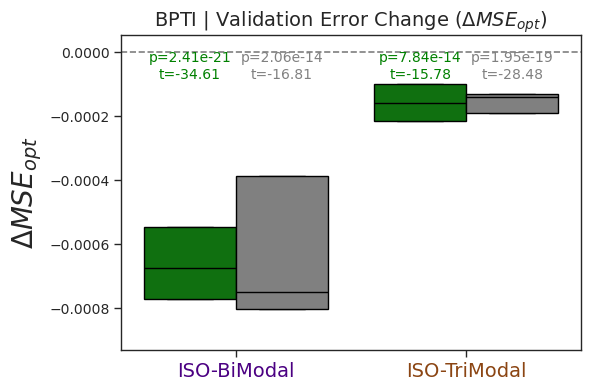

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")
y_metric = "dMSE"

def perform_one_sample_ttest(data, ensemble, split):
    """
    Perform one-sample t-test against 0 for a given ensemble and split.
    """
    group = data[(data['ensemble'] == ensemble) & 
                 (data['split_name'] == split)][y_metric].dropna()
    
    if len(group) > 0:
        t_stat, p_val = stats.ttest_1samp(group, 0)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split} split for {ensemble}")
        print(f"Group size: {len(group)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))

_dMSE_energy_df = dMSE_energy_df.copy()
# drop nan rows
_dMSE_energy_df = _dMSE_energy_df.dropna()
# Create box plot with explicit ordering and no legend
sns.boxplot(data=dMSE_energy_df,
            x='ensemble',
            y=y_metric,
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax,
            palette=split_name_dataset_colours,
            legend=False)  # Disable the legend here

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", fontsize=14)

# Calculate box positions dynamically based on ensemble and split indices
n_ensembles = len(ensemble_order)
n_splits = len(split_name_dataset_order)
hue_offset = 0.2  # Default offset for two splits in seaborn

# Perform t-tests and add annotations for each box
for ensemble in ensemble_order:
    for split in split_name_dataset_order:
        # Get indices for positioning
        ensemble_idx = ensemble_order.index(ensemble)
        split_idx = split_name_dataset_order.index(split)
        
        # Calculate x position: main position + hue offset
        x_pos = ensemble_idx + (-hue_offset if split_idx == 0 else hue_offset)
        
        # Perform t-test
        t_stat, p_val = perform_one_sample_ttest(dMSE_energy_df, ensemble, split)
        
        # Determine y position (slightly above the top of the highest box)
        y_pos = y_max + 0.01 * y_range
        
        # Add text annotation
        ax.text(x_pos, y_pos,
                f'p={p_val:.2e}\nt={t_stat:.2f}',
                ha='center',
                va='bottom',
                fontsize=10,
                color=split_name_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.2 * y_range)

plt.tight_layout()
plt.show()

In [164]:
fit_val_df

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
34,0.167,Val,NaN,val_TeaA_ISO_bi_1,0.011000,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1
35,0.167,Val,NaN,val_TeaA_ISO_bi_2,0.007390,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,2
36,0.167,Val,NaN,val_TeaA_ISO_bi_3,0.013551,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,3
41,1.000,Val,NaN,val_TeaA_ISO_bi_1,0.014072,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1
42,1.000,Val,NaN,val_TeaA_ISO_bi_2,0.010361,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,60.000,Val,NaN,val_TeaA_ISO_tri_2,0.009942,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,2
57,60.000,Val,NaN,val_TeaA_ISO_tri_3,0.009443,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,3
62,120.000,Val,NaN,val_TeaA_ISO_tri_1,0.010157,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,1
63,120.000,Val,NaN,val_TeaA_ISO_tri_2,0.007994,TeaA_ISO_tri_RW_bench_R3_k_sequence,TeaA_ISO_tri_RW_bench_R3_k_sequence,RW,R3,TeaA,TeaA_ISO_tri_RW_bench_R3_k_sequence_val_TeaA_I...,val,val_R3,tri,RW,ISO-TriModal,Non-Redundant,2


In [165]:
_fit_val_df = fit_val_df[fit_val_df["split_type"].isin(["R3", "Sp"])]
_fit_val_df = _fit_val_df[_fit_val_df["ensemble"].isin(ensemble_order)]
_fit_val_df

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
34,0.167,Val,NaN,val_TeaA_ISO_bi_1,0.011000,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1
35,0.167,Val,NaN,val_TeaA_ISO_bi_2,0.007390,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,2
36,0.167,Val,NaN,val_TeaA_ISO_bi_3,0.013551,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,3
41,1.000,Val,NaN,val_TeaA_ISO_bi_1,0.014072,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1
42,1.000,Val,NaN,val_TeaA_ISO_bi_2,0.010361,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,2
43,1.000,Val,NaN,val_TeaA_ISO_bi_3,0.018082,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,3
48,10.000,Val,NaN,val_TeaA_ISO_bi_1,0.010736,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1
49,10.000,Val,NaN,val_TeaA_ISO_bi_2,0.003527,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,2
50,10.000,Val,NaN,val_TeaA_ISO_bi_3,0.011709,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,3
55,60.000,Val,NaN,val_TeaA_ISO_bi_1,0.011688,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,TeaA_ISO_bi_RW_bench_Sp_res_neighbours,RW,Sp,TeaA,TeaA_ISO_bi_RW_bench_Sp_res_neighbours_val_Tea...,val,val_Sp,bi,RW,ISO-BiModal,Spatial,1


In [166]:
fit_val_df.ensemble.unique()

array(['ISO-BiModal', 'ISO-TriModal'], dtype=object)

In [167]:
ensemble_order

['ISO-BiModal', 'ISO-TriModal']

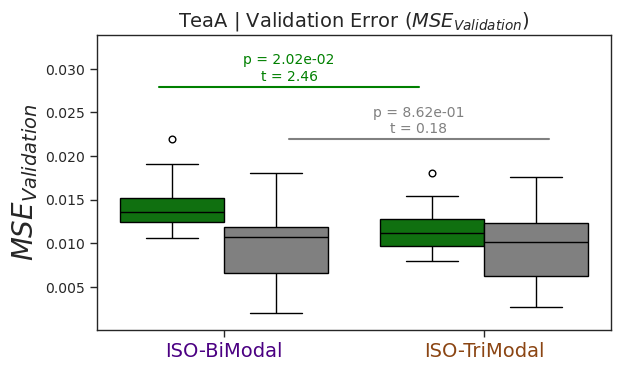

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "mse"
_fit_val_df = fit_val_df[fit_val_df["split_type"].isin(["R3", "Sp"])]
_fit_val_df = _fit_val_df[_fit_val_df["ensemble"].isin(ensemble_order)]

_fit_val_df
def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=_fit_val_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = _fit_val_df[y_metric].max()
y_min = _fit_val_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "TeaA"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", fontsize=14)

# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.2
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(_fit_val_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + (idx * 0.3) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            f'p = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.6 * y_range)

plt.tight_layout(rect=[0.1, 0, 1, 0.95])
plt.show()


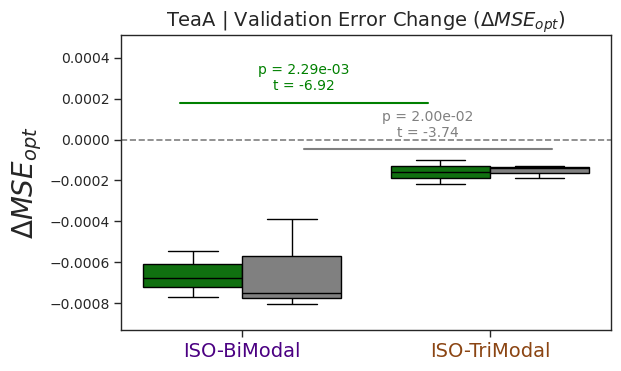

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "dMSE"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_ensemble_pmf_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_ensemble_pmf_df[y_metric].max()
y_min = dMSE_ensemble_pmf_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "TeaA"  # Replace with actual protein name if available
# plt.title(f"{protein_name} | {metric_name}", fontsize=20, pad=20)
plt.title(f"{protein_name} | {metric_name}", fontsize=14)
# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.3
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_ensemble_pmf_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + 0.00005 + ( idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.00001 + (0.05 * y_range),
            f'p = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.8 * y_range)

plt.tight_layout(rect=[0.1, 0, 1, 0.95])
plt.show()


In [170]:
dMSE_energy_df.columns

Index(['name', 'replicate', 'dMSE', 'Bc', 'Bh', 'calc_name', 'system',
       'analysis', 'split_type', 'protein', 'name_name', 'dataset', 'class',
       'weights', 'sum_contacts', 'sum_hbonds', 'energy', 'weighted_energy',
       'mean_energy', 'method', 'fit', 'ensemble', 'split_name',
       'Entropy_nats', 'Entropy_JKmol', 'signed_energy_difference',
       'energy_difference', '%_energy_difference', 'ratio_energy_difference',
       'entropy_difference', 'signed_enthalpy', 'gibbs_free_energy',
       'equilibrium_constant'],
      dtype='object')

In [171]:
dMSE_energy_df.columns

Index(['name', 'replicate', 'dMSE', 'Bc', 'Bh', 'calc_name', 'system',
       'analysis', 'split_type', 'protein', 'name_name', 'dataset', 'class',
       'weights', 'sum_contacts', 'sum_hbonds', 'energy', 'weighted_energy',
       'mean_energy', 'method', 'fit', 'ensemble', 'split_name',
       'Entropy_nats', 'Entropy_JKmol', 'signed_energy_difference',
       'energy_difference', '%_energy_difference', 'ratio_energy_difference',
       'entropy_difference', 'signed_enthalpy', 'gibbs_free_energy',
       'equilibrium_constant'],
      dtype='object')

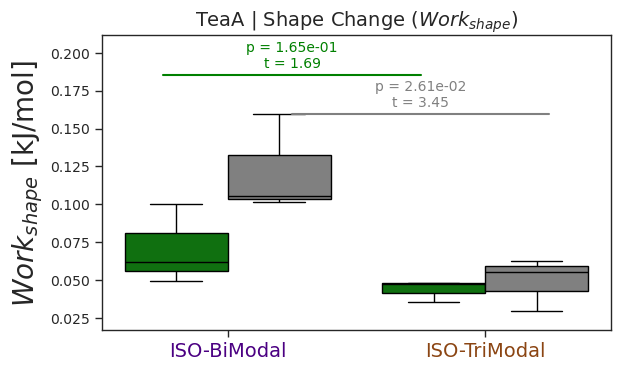

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "delta_H_opt_kj"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_ensemble_pmf_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_ensemble_pmf_df[y_metric].max()
y_min = dMSE_ensemble_pmf_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "TeaA"  # Replace with actual protein name if available
# plt.title(f"{protein_name} | {metric_name}", fontsize=20, pad=20)
plt.title(f"{protein_name} | {metric_name}", fontsize=14)
# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.2
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_ensemble_pmf_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + ( idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            f'p = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout(rect=[0.1, 0, 1, 0.95])
plt.show()


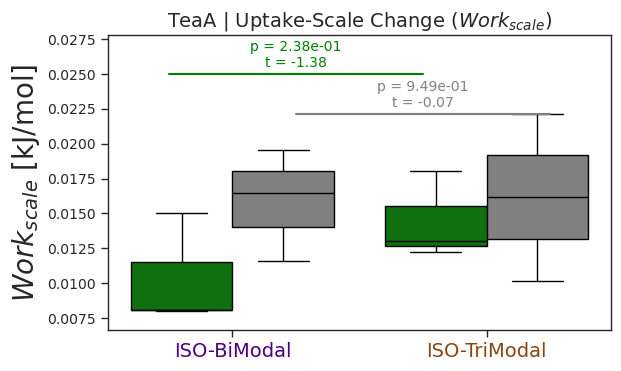

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "delta_H_abs_kj"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_ensemble_pmf_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_ensemble_pmf_df[y_metric].max()
y_min = dMSE_ensemble_pmf_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "TeaA"  # Replace with actual protein name if available
# plt.title(f"{protein_name} | {metric_name}", fontsize=20, pad=20)
plt.title(f"{protein_name} | {metric_name}", fontsize=14)
# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.2
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_ensemble_pmf_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + ( idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            f'p = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout(rect=[0.1, 0, 1, 0.95])
plt.show()


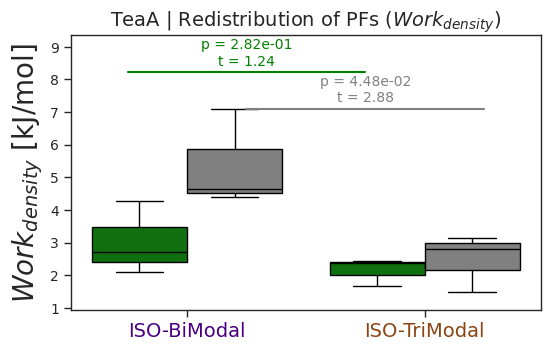

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "-Tdelta_S_opt_kj"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_ensemble_pmf_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_ensemble_pmf_df[y_metric].max()
y_min = dMSE_ensemble_pmf_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "TeaA"  # Replace with actual protein name if available
# plt.title(f"{protein_name} | {metric_name}", fontsize=20, pad=20)
plt.title(f"{protein_name} | {metric_name}", fontsize=14)
# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.2
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_ensemble_pmf_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + ( idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            f'p = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout(rect=[0.1, 0, 0.9, 0.9])
plt.show()


Metric: mse, Split: Sp, p-val: 0.8622445901462359
Metric: mse, Split: R3, p-val: 0.020218927009340387
Metric: dMSE, Ensemble: ISO-BiModal, Split: Non-Redundant, p-val: 0.009462059035804543
Metric: dMSE, Ensemble: ISO-BiModal, Split: Spatial, p-val: 0.03837193868357274
Metric: dMSE, Ensemble: ISO-TriModal, Split: Non-Redundant, p-val: 0.04319341171774227
Metric: dMSE, Ensemble: ISO-TriModal, Split: Spatial, p-val: 0.01388753993362287
Metric: delta_H_opt_kj, Split: Sp, p-val: 0.03979277094894979
Metric: delta_H_opt_kj, Split: R3, p-val: 0.21664112896690743
Metric: -Tdelta_S_opt_kj, Split: Sp, p-val: 0.05799886354446794
Metric: -Tdelta_S_opt_kj, Split: R3, p-val: 0.31513571827316195


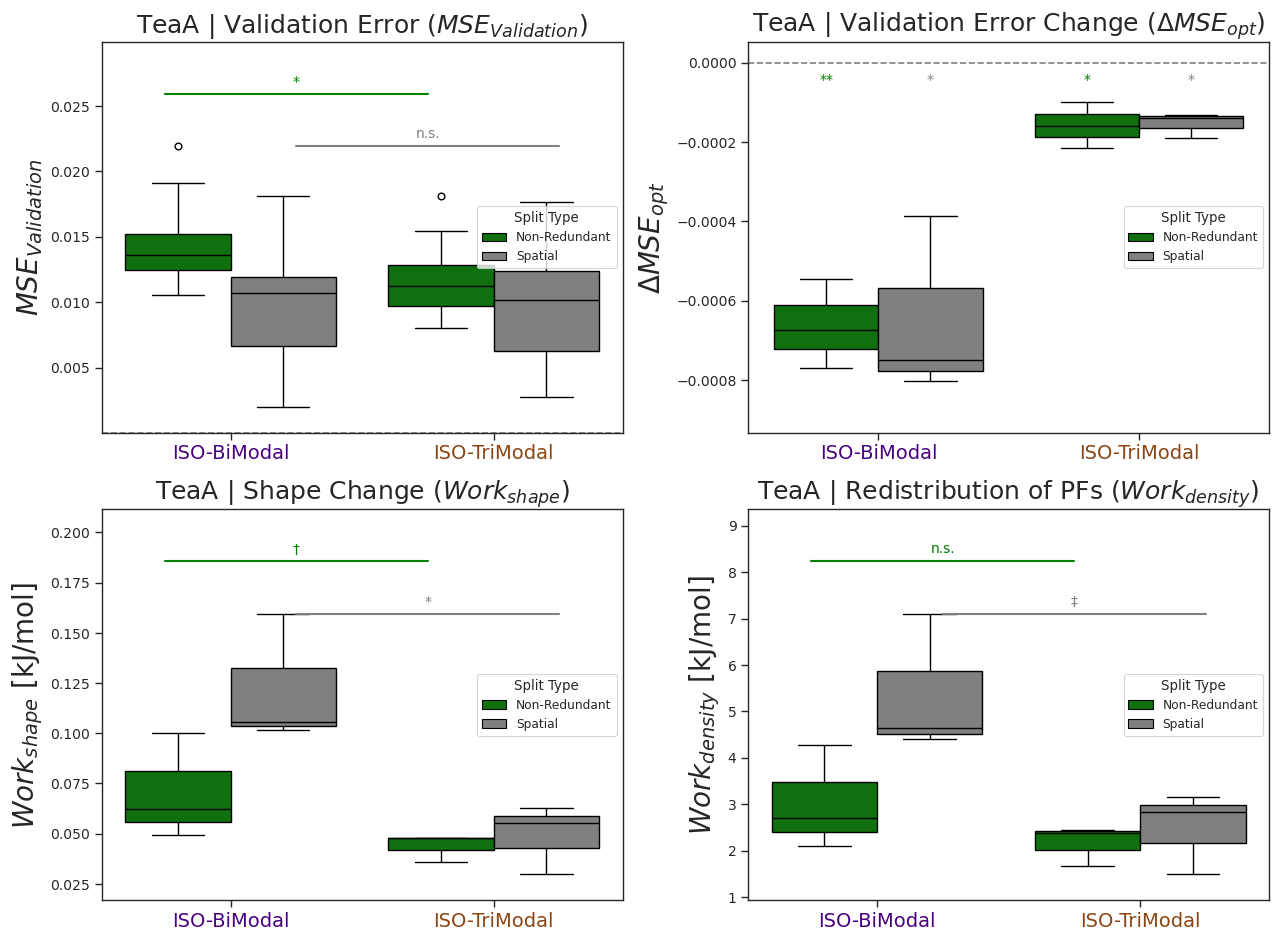

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

def perform_ttest(data, ensemble1, ensemble2, split_type, y_metric):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) &
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) &
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

def perform_one_sample_ttest(data, ensemble, split, y_metric):
    """
    Perform one-sample t-test against 0 for a given ensemble and split.
    """
    group = data[(data['ensemble'] == ensemble) &
                 (data['split_name'] == split)][y_metric].dropna()
    
    if len(group) > 0:
        t_stat, p_val = stats.ttest_1samp(group, 0)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split} split for {ensemble}")
        print(f"Group size: {len(group)}")
        return float('nan'), float('nan')
    
def p_to_stars(p_val):
    """Convert p-value to significance stars."""
    if pd.isna(p_val):
        return 'n.s.'
    elif p_val < 0.0001:
        return '****'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    elif p_val < 0.1:
        return '‡'  # Unicode double dagger (U+2021)
    elif p_val < 0.25:
        return '†'  # Unicode single dagger (U+2020)
    else:
        return 'n.s.'

# Create the main figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle("BPTI Analysis - Four Metrics Comparison", fontsize=16, y=0.98)

# Define metrics and data sources for each subplot
metrics_info = [
    {"metric": "mse", "data": "fit_val_df", "row": 0, "col": 0},
    {"metric": "dMSE", "data": "dMSE_ensemble_pmf_df", "row": 0, "col": 1},
    {"metric": "delta_H_opt_kj", "data": "dMSE_ensemble_pmf_df", "row": 1, "col": 0},
    {"metric": "-Tdelta_S_opt_kj", "data": "dMSE_ensemble_pmf_df", "row": 1, "col": 1}
]

stats_texts = {}

# Plot each metric
for info in metrics_info:
    y_metric = info["metric"]
    ax = axes[info["row"], info["col"]]
    
    # Select appropriate data source
    if info["data"] == "fit_val_df":
        data = fit_val_df
        # Filter data for first plot
        data = data[data["split_type"].isin(["R3", "Sp"])]
        data = data[data["ensemble"].isin(full_dataset_order)]
    else:
        data = dMSE_ensemble_pmf_df
    
    # Create box plot
    sns.boxplot(data=data,
                x='ensemble',
                y=y_metric,
                hue='split_name',
                order=ensemble_order,
                hue_order=split_name_dataset_order,
                ax=ax,
                palette=split_name_dataset_colours)
    
    # Get plot limits
    y_max = data[y_metric].max()
    y_min = data[y_metric].min()
    y_range = y_max - y_min
    
    # Add title using metric_name_mapping
    metric_title = metric_name_mapping.get(y_metric, y_metric)
    ax.set_title(f"TeaA | {metric_title}", fontsize=18)
    
    # Handle different annotation styles based on metric
    if y_metric == "dMSE":
        # One-sample t-tests for dMSE
        n_ensembles = len(ensemble_order)
        hue_offset = 0.2
        
        stats_texts[y_metric] = {}
        
        for ensemble in ensemble_order:
            stats_texts[y_metric][ensemble] = {}
            for split in split_name_dataset_order:
                ensemble_idx = ensemble_order.index(ensemble)
                split_idx = split_name_dataset_order.index(split)
                x_pos = ensemble_idx + (-hue_offset if split_idx == 0 else hue_offset)
                
                t_stat, p_val = perform_one_sample_ttest(data, ensemble, split, y_metric)
                stars = p_to_stars(p_val)
                y_pos = y_max + 0.05 * y_range
                print(f"Metric: {y_metric}, Ensemble: {ensemble}, Split: {split}, p-val: {p_val}")
            
                ax.text(x_pos, y_pos, stars,
                       ha='center', va='bottom', fontsize=10,
                       color=split_name_dataset_colours[split])
                
    else:
        # Two-sample t-tests for other metrics
        box_positions = {'Sp': 0.25, 'R3': -0.25}
        split_order = ["Sp", "R3"]
        spacing_factor = 0.2
        
        stats_texts[y_metric] = {}
        
        for idx, split in enumerate(split_order):
            stats_texts[y_metric][split] = {}
            if info["data"] == "fit_val_df":
                t_stat, p_val = perform_ttest(data, ensemble_order[0], ensemble_order[1], split, y_metric)
            else:
                # For dMSE_energy_df, need to map split names properly
                split_type_map = {'Sp': 'Sp', 'R3': 'R3'}  # Adjust as needed
                t_stat, p_val = perform_ttest(data, ensemble_order[0], ensemble_order[1], 
                                            split_type_map.get(split, split), y_metric)
            
            base_height = y_max + (idx * spacing_factor) * y_range
            
            # Add significance bar
            ax.plot([box_positions[split], 1 + box_positions[split]],
                   [base_height, base_height], '-',
                   color=split_type_dataset_colours[split], linewidth=1.5)
            stars = p_to_stars(p_val)
            print(f"Metric: {y_metric}, Split: {split}, p-val: {p_val}")
            ax.text(0.5 + box_positions[split], base_height + 0.02 * y_range, stars,
                   ha='center', va='bottom', fontsize=10,
                   color=split_type_dataset_colours[split])
            
    
    # Customize each subplot
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_ylabel(metric_axis_mapping.get(y_metric, y_metric))
    ax.set_xlabel('')
    ax.legend(title='Split Type', loc='right')
    # Set x-tick labels with colors
    ax.set_xticks(range(len(ensemble_order)))
    labels = ax.set_xticklabels(ensemble_order)
    for idx, label in enumerate(labels):
        label.set_color(full_dataset_colours[ensemble_order[idx]])
    
    # Remove individual legends (we'll add a shared one)
    # if ax.get_legend():
    #     ax.get_legend().remove()
    
    # Adjust y-axis limits
    if y_metric == "dMSE":
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.2 * y_range)

    else:
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

# Create a shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, title='Split Type', loc='center right', 
#            bbox_to_anchor=(0.55, 0.48), fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()


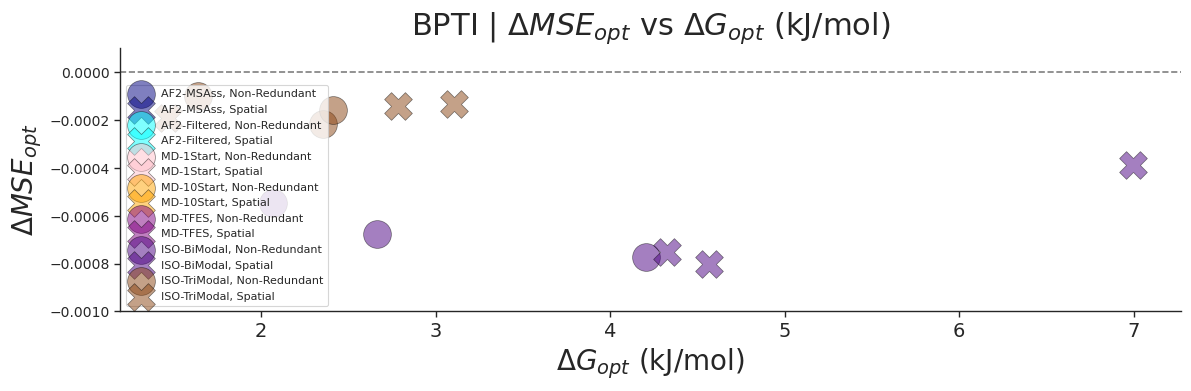

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set publication-ready style
sns.set_style("ticks")

# Filter the dataframe
dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["ensemble"].isin(full_dataset_colours.keys())]

# Create figure with specific size for publication
fig, ax = plt.subplots(figsize=(12,4))

# Create scatter plot with publication-ready formatting
for ensemble in full_dataset_colours.keys():
    for split, marker in {'Non-Redundant': 'o', 'Spatial': 'X'}.items():
        # Filter data for this ensemble and split
        subset = dMSE_energy_df[(dMSE_energy_df['ensemble'] == ensemble) & 
                              (dMSE_energy_df['split_name'] == split)]
        
        # Plot with appropriate styling
        ax.scatter(subset['delta_G_opt_kj'], subset['dMSE'],
                  color=full_dataset_colours[ensemble],
                  marker=marker,
                  s=400,
                  alpha=0.5,
                  label=f"{ensemble}, {split}",
                  edgecolor='k',
                  linewidth=0.5)

# add title
metric_name1 = metric_axis_mapping.get("dMSE", 'Unknown Metric')
metric_name2 = metric_axis_mapping.get("delta_G_opt_kj", 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name1} vs {metric_name2}", fontsize=22, pad=10)
# 
# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Format axes for publication
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=4, width=1)

# Set labels using standardized mapping
ax.set_xlabel(metric_axis_mapping["delta_G_opt_kj"], fontsize=20)
ax.set_ylabel(metric_axis_mapping["dMSE"], fontsize=20)

# Set axis limits
ax.set_ylim((-0.001, 0.0001))

# Create custom legend with both ensemble and split type represented
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(fontsize=8, frameon=True, loc='lower left')

# Finalize layout and display
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

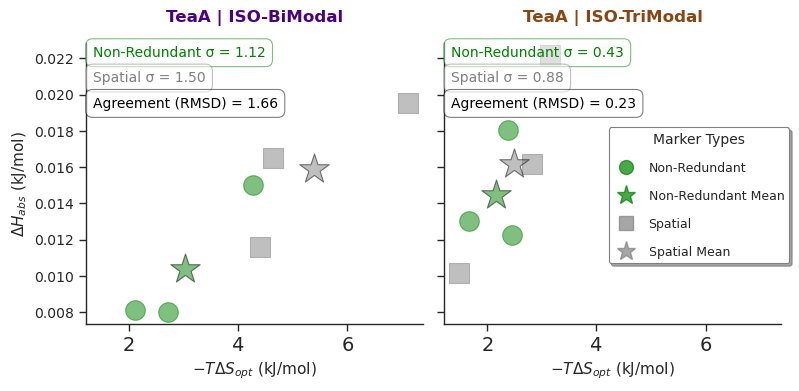

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order and use the new naming system
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_order)]

# Force the order of the datasets using new naming
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], 
                                            categories=selected_dataset_colours, 
                                            ordered=True)

# Define consistent styles for split types using new color scheme
split_styles = {
    'R3': {'marker': 'o', 'color': split_type_dataset_colours['R3']},
    'Sp': {'marker': 's', 'color': split_type_dataset_colours['Sp']}
}

# Set figure style
# plt.style.use('white')
# sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style("ticks")
# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=4, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=200,
                  label=split_name_mapping[split_type],
                  alpha=0.5)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    means = {}  # Store means for MSD calculation
    
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            means[split_type] = np.array([mean_x, mean_y])
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with darker version of split type color
            ax.scatter(mean_x, mean_y, 
                      marker='*', 
                      s=500,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Mean',
                      alpha=0.5,
                      zorder=5)
            
            # Add std dev annotation with refined styling
            ax.annotate(f'{split_name_mapping[split_type]} σ = {mult_std:.2f}',
                       xy=(0.02, 0.95 - (0.09 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white',
                                edgecolor=style['color'],
                                alpha=0.5,
                                boxstyle='round,pad=0.5'))
    
    # Calculate and annotate MSD between means if we have both split types
    if len(means) == 2:
        msd = np.mean((means['R3'] - means['Sp'])**2)**0.5
        ax.annotate(f'Agreement (RMSD) = {msd:.2f}',
                   xy=(0.02, 0.77),  # Position below the other annotations
                   xycoords='axes fraction',
                   fontsize=10,
                   color='black',
                   bbox=dict(facecolor='white',
                            edgecolor='black',
                            alpha=0.5,
                            boxstyle='round,pad=0.5'))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Custom function to set colored titles with refined styling
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            parts = title.split(" | ")
            if len(parts) == 2:
                protein, ensemble = parts
                new_title = f"{protein} | "
                ax.set_title(new_title + ensemble, 
                           color=full_dataset_colours[ensemble],
                           pad=15,
                           fontsize=12,
                           fontweight='bold')

# Set and style titles
g.set_titles(row_template="{row_name}", col_template="{col_name}")
set_colored_titles(g.fig)

# Add styled axis labels
g.set_axis_labels(metric_axis_mapping["-Tdelta_S_opt_kj"], 
                 metric_axis_mapping["delta_H_abs_kj"],
                 fontsize=11)

# Create refined legend elements
handles = []
labels = []

for split_type, style in split_styles.items():
    # Data points with refined styling
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.7,
                            label=split_name_mapping[split_type]))
    # Mean markers with refined styling
    handles.append(plt.Line2D([0], [0], 
                            marker='*',
                            color=style['color'],
                            linestyle='None',
                            markersize=14,
                            alpha=0.7,
                            label=f'{split_name_mapping[split_type]} Mean'))
    labels.extend([split_name_mapping[split_type], 
                  f'{split_name_mapping[split_type]} Mean'])

# Add refined legend
g.fig.legend(handles, labels, 
            loc='center right',
            bbox_to_anchor=(1, 0.5),
            title="Marker Types",
            title_fontsize=10,
            fontsize=9,
            frameon=True,
            edgecolor='gray',
            fancybox=True,
            shadow=True,
            # borderpad=1,
            labelspacing=1.2)

# Final layout adjustments
plt.tight_layout()
# g.fig.subplots_adjust(right=0.85)  # Make room for legend
# set yscale to log
plt.show()

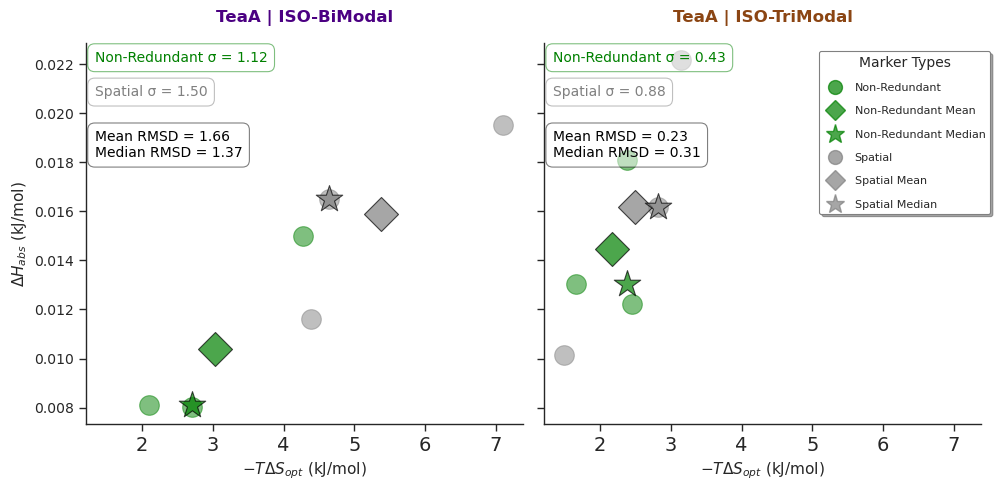

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order and use the new naming system
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_colours)]

# Force the order of the datasets using new naming
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], 
                                            categories=selected_dataset_colours, 
                                            ordered=True)

# Define consistent styles for split types using new color scheme
split_styles = {
    'R3': {'marker': 'o', 'color': split_type_dataset_colours['R3']},
    'Sp': {'marker': 'o', 'color': split_type_dataset_colours['Sp']}
}

# Set figure style
sns.set_style("ticks")

# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=5, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=200,
                  label=split_name_mapping[split_type],
                  alpha=0.5)

# Function to calculate and annotate means, medians, and stats with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    means = {}  # Store means for RMSD calculation
    medians = {}  # Store medians for RMSD calculation
    
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["-Tdelta_S_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            means[split_type] = np.array([mean_x, mean_y])
            medians[split_type] = np.array([median_x, median_y])
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with diamond marker
            ax.scatter(mean_x, mean_y, 
                      marker='D',  # Diamond for mean
                      s=300,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Mean',
                      alpha=0.7,
                      zorder=5)
            
            # Plot median with star marker
            ax.scatter(median_x, median_y, 
                      marker='*',  # Star for median
                      s=400,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Median',
                      alpha=0.7,
                      zorder=5)
            
            # Add std dev annotation with refined styling
            ax.annotate(f'{split_name_mapping[split_type]} σ = {mult_std:.2f}',
                       xy=(0.02, 0.95 - (0.09 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white',
                                edgecolor=style['color'],
                                alpha=0.5,
                                boxstyle='round,pad=0.5'))
    
    # Calculate and annotate RMSD between means and medians if we have both split types
    if len(means) == 2 and len(medians) == 2:
        mean_rmsd = np.sqrt(np.mean((means['R3'] - means['Sp'])**2))
        median_rmsd = np.sqrt(np.mean((medians['R3'] - medians['Sp'])**2))
        
        # Add RMSD annotations
        ax.annotate(f'Mean RMSD = {mean_rmsd:.2f}\nMedian RMSD = {median_rmsd:.2f}',
                   xy=(0.02, 0.7),
                   xycoords='axes fraction',
                   fontsize=10,
                   color='black',
                   bbox=dict(facecolor='white',
                            edgecolor='black',
                            alpha=0.5,
                            boxstyle='round,pad=0.5'))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Custom function to set colored titles with refined styling
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            parts = title.split(" | ")
            if len(parts) == 2:
                protein, ensemble = parts
                new_title = f"{protein} | "
                ax.set_title(new_title + ensemble, 
                           color=full_dataset_colours[ensemble],
                           pad=15,
                           fontsize=12,
                           fontweight='bold')

# Set and style titles
g.set_titles(row_template="{row_name}", col_template="{col_name}")
set_colored_titles(g.fig)

# Add styled axis labels
g.set_axis_labels(metric_axis_mapping["-Tdelta_S_opt_kj"], 
                 metric_axis_mapping["delta_H_abs_kj"],
                 fontsize=11)

# Create refined legend elements
handles = []
labels = []

for split_type, style in split_styles.items():
    # Data points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.7,
                            label=split_name_mapping[split_type]))
    # Mean markers
    handles.append(plt.Line2D([0], [0], 
                            marker='D',  # Diamond for mean
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.7,
                            label=f'{split_name_mapping[split_type]} Mean'))
    # Median markers
    handles.append(plt.Line2D([0], [0], 
                            marker='*',  # Star for median
                            color=style['color'],
                            linestyle='None',
                            markersize=14,
                            alpha=0.7,
                            label=f'{split_name_mapping[split_type]} Median'))
    labels.extend([
        split_name_mapping[split_type],
        f'{split_name_mapping[split_type]} Mean',
        f'{split_name_mapping[split_type]} Median'
    ])

# Add refined legend
g.fig.legend(handles, labels, 
            loc='upper right',
            bbox_to_anchor=(1, 0.9),
            title="Marker Types",
            title_fontsize=10,
            fontsize=8,
            frameon=True,
            edgecolor='gray',
            facecolor='white',
            # set transparent 
            # framealpha=0.5,
            
            fancybox=True,
            shadow=True,
            labelspacing=1.2)

# Final layout adjustments
plt.tight_layout()
plt.show()

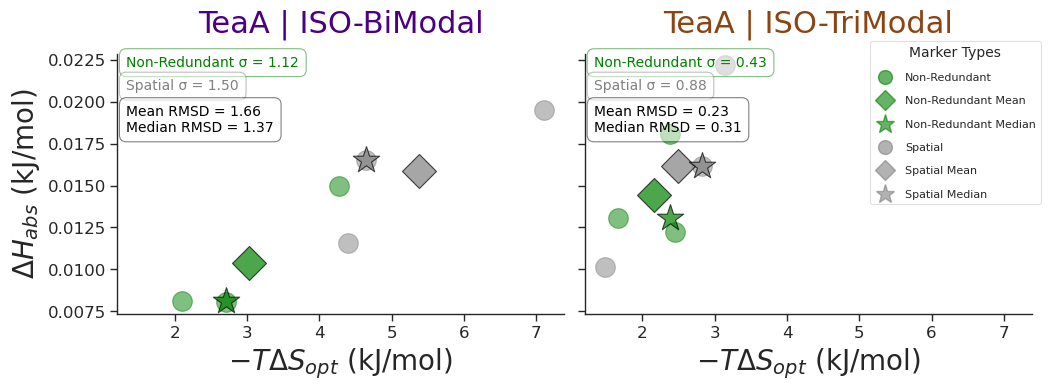

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order and use the new naming system
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_order)]

# Force the order of the datasets using new naming
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], 
                                            categories=selected_dataset_colours, 
                                            ordered=True)
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["protein"] == protein]
# Define consistent styles for split types using new color scheme
split_styles = {
    'R3': {'marker': 'o', 'color': split_type_dataset_colours['R3']},
    'Sp': {'marker': 'o', 'color': split_type_dataset_colours['Sp']}
}

# Set figure style
sns.set_style("ticks")

# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                #   row="protein",
                 col_wrap=2, 
                  col="ensemble", 
                  height=4, 
                  aspect=1.3, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=200,
                  label=split_name_mapping[split_type],
                  alpha=0.5)

# Function to calculate and annotate means, medians, and stats with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    means = {}  # Store means for RMSD calculation
    medians = {}  # Store medians for RMSD calculation
    
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["-Tdelta_S_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            means[split_type] = np.array([mean_x, mean_y])
            medians[split_type] = np.array([median_x, median_y])
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with diamond marker
            ax.scatter(mean_x, mean_y, 
                      marker='D',  # Diamond for mean
                      s=300,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Mean',
                      alpha=0.7,
                      zorder=5)
            
            # Plot median with star marker
            ax.scatter(median_x, median_y, 
                      marker='*',  # Star for median
                      s=400,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Median',
                      alpha=0.7,
                      zorder=5)
            
            # Add std dev annotation with refined styling
            ax.annotate(f'{split_name_mapping[split_type]} σ = {mult_std:.2f}',
                       xy=(0.02, 0.95 - (0.09 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white',
                                edgecolor=style['color'],
                                alpha=0.5,
                                boxstyle='round,pad=0.5'))
    
    # Calculate and annotate RMSD between means and medians if we have both split types
    if len(means) == 2 and len(medians) == 2:
        mean_rmsd = np.sqrt(np.mean((means['R3'] - means['Sp'])**2))
        median_rmsd = np.sqrt(np.mean((medians['R3'] - medians['Sp'])**2))
        
        # Add RMSD annotations
        ax.annotate(f'Mean RMSD = {mean_rmsd:.2f}\nMedian RMSD = {median_rmsd:.2f}',
                   xy=(0.02, 0.7),
                   xycoords='axes fraction',
                   fontsize=10,
                   color='black',
                   bbox=dict(facecolor='white',
                            edgecolor='black',
                            alpha=0.5,
                            boxstyle='round,pad=0.5'))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Custom function to set colored titles with refined styling
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            # The title should just be the ensemble name
            ensemble = title.strip()
            if ensemble in full_dataset_colours:
                ax.set_title(f"{protein} | {ensemble}", 
                           color=full_dataset_colours[ensemble],
                           pad=15,
                           fontsize=22,)
                        #    fontweight='bold')

# Set and style titles
g.set_titles(col_template="{col_name}")  # Use only the column name
set_colored_titles(g.fig)

# Add styled axis labels to all subplots
# g.set_axis_labels(metric_axis_mapping["-Tdelta_S_opt_kj"], 
#                  metric_axis_mapping["delta_H_abs_kj"],
#                  fontsize=20)

# Ensure axis labels are visible on all subplots
for ax in g.axes.flat:
    ax.set_xlabel(metric_axis_mapping["-Tdelta_S_opt_kj"], fontsize=20)
    ax.set_ylabel(metric_axis_mapping["delta_H_abs_kj"], fontsize=20)
    # Make tick labels more readable
    ax.tick_params(axis='both', which='major', labelsize=12)

# Create refined legend elements
handles = []
labels = []

for split_type, style in split_styles.items():
    # Data points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.6,
                            label=split_name_mapping[split_type]))
    # Mean markers
    handles.append(plt.Line2D([0], [0], 
                            marker='D',  # Diamond for mean
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.6,
                            label=f'{split_name_mapping[split_type]} Mean'))
    # Median markers
    handles.append(plt.Line2D([0], [0], 
                            marker='*',  # Star for median
                            color=style['color'],
                            linestyle='None',
                            markersize=14,
                            alpha=0.6,
                            label=f'{split_name_mapping[split_type]} Median'))
    labels.extend([
        split_name_mapping[split_type],
        f'{split_name_mapping[split_type]} Mean',
        f'{split_name_mapping[split_type]} Median'
    ])

# Add refined legend
g.fig.legend(handles, labels, 
            loc='upper right',
            bbox_to_anchor=(1, 0.9),
            title="Marker Types",
            title_fontsize=10,
            fontsize=8,
            frameon=True,
            # edgecolor='gray',
            # facecolor='white'

            # set transparent 
            framealpha=0.6,
            
            fancybox=True,
            # shadow=True,
            labelspacing=1.2)

# Final layout adjustments
plt.tight_layout()
plt.show()
